# **전교희장 이지민 코드 통합본**
- **주제**: 이커머스 고객 세분화 및 마케팅 전략 수립
- **사용 데이터**: 쿠팡 고객 리뷰 데이터, 테무 고객 리뷰 데이터
---

**코드 통합본 흐름**
1. 전처리  
1-1. 스크래핑 데이터 변환 및 통합  
[테무]  
: (홈&주방)테무 전처리_200.ipynb  
- 스크래핑한 리뷰 데이터 리스트로 변환  
- 컬럼 순서 지정  
- 테무 팀원별 스크래핑 데이터 병합(각자+400행)  
- 테무 중복행 제거 및 1000행 맞추기  

[쿠팡]  
: 희영 언니 코드(vscode)  

1-2. 파생 변수 생성  
: 선교 코드  
-

1-3. 맞춤법 검사  
: vscode 코드  
- hanspell 라이브러리  
- 테무 코드  
- 쿠팡 코드  


2. 감성 분석
: 희영언니 코드
-

3. 클러스터링  
: 선교 코드  
-


# 1. 전처리

## 1.1. 스크래핑 데이터 변환 및 통합

### [쿠팡]

In [ ]:
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import random
import time
from fake_useragent import UserAgent

# 헤더를 랜덤하게 설정하여 서버 차단 방지
def set_header() -> dict[str, str]:
    return {
        "User-Agent": UserAgent().random,
        "Accept-Language": "ko-KR,ko;q=0.8,en-US;q=0.5,en;q=0.3"
    }

# 크롬 드라이버 기본 설정 코드
def set_chrome_driver():
    options = webdriver.ChromeOptions()
    options.add_argument("--disable-blink-features=AutomationControlled")
    options.add_argument(f"user-agent={UserAgent().random}")
    options.add_experimental_option("excludeSwitches", ["enable-automation"])
    options.add_experimental_option("useAutomationExtension", False)
    options.add_experimental_option("prefs", {"profile.managed_default_content_settings.images": 2})
    service = Service(executable_path='C:/Users/LG/OneDrive/바탕 화면/DArt-B/4기/project/chromedriver-win64/chromedriver-win64/chromedriver.exe')

    driver = webdriver.Chrome(service=service, options=options)
    return driver

# 크롤링 함수 생성
def scrape_reviews():
    driver = set_chrome_driver()

    # 웹 사이트 url (본인의 카테고리 페이지로 변경!!)
    url = "https://www.coupang.com/np/categories/114473?listSize=60&brand=&offerCondition=&filterType=&isPriceRange=false&minPrice=&maxPrice=&channel=user&fromComponent=N&selectedPlpKeepFilter=&sorter=bestAsc&filter=&component=120474&rating=0"
    driver.get(url)

    time.sleep(random.uniform(5, 10)) # 랜덤 대기시간 설정

    reviews_data = []

    ### [몇 페이지의 상품 목록에서 가져올지(페이지 번호) 입력] ###
    # /div/a[3] <- 이 부분에서 3이 쓰인 자리에 원하는 페이지 번호+1 을 입력하면 돼여
    element = driver.find_element(By.XPATH, f'//*[@id="product-list-paging"]/div/a[3]')
    driver.execute_script("arguments[0].click();", element)
    time.sleep(random.uniform(3, 5))  # 페이지 로딩 대기

    try:
        for i in range(120): # 몇 개의 상품을 순회하며 가져올지 입력

            # 상품 리스트에서 개별 상품을 하나씩 클릭 > 상품 페이지로 진입
            product_list = driver.find_element(By.CLASS_NAME, "baby-product-list")
            lis = product_list.find_elements(By.CLASS_NAME, "baby-product-link")
            lis[i].click()
            time.sleep(random.uniform(3, 5))

            # 상품 페이지에서 리뷰 탭 클릭
            try:
                review_tab = WebDriverWait(driver, 10).until(
                    EC.element_to_be_clickable((By.NAME, "review"))
                )
                review_tab.click()
                time.sleep(random.uniform(2, 5))

                # 리뷰 탭 내에서 데이터를 수집할 시작 페이지, 끝 페이지 설정
                start_page = 5
                last_page = 8
                for page_num in range(start_page, last_page+1):
                    review_container = driver.find_element(By.CLASS_NAME, "js_reviewArticleListContainer")
                    review_list = review_container.find_elements(By.CLASS_NAME, "sdp-review__article__list")

                    for review in review_list:
                        try:
                            # 개별 고객 페이지로 진입
                            reviewer_name = review.find_element(By.CLASS_NAME, "sdp-review__article__list__info__user__name")
                            reviewer_name.click()
                            time.sleep(random.uniform(2, 4))

                            # 사용자 기본 정보 수집
                            user_name = driver.find_element(By.CLASS_NAME, "sdp-review__profile__article__info__name").text
                            helpful_count = driver.find_element(By.CLASS_NAME, "sdp-review__profile__article__info__helpful__count").text
                            review_count = driver.find_element(By.CLASS_NAME, "sdp-review__profile__article__info__write__count").text

                            # 리뷰 관련 데이터를 수집할 리스트
                            has_image_list = []
                            dates_list = []
                            ratings_list = []
                            contents_list = []

                            # 팝업의 전체 스크롤 길이 가져오기
                            popup = driver.find_element(By.CLASS_NAME, "js_reviewModalGroup")
                            scroll_height = driver.execute_script("return arguments[0].scrollHeight;", popup)
                            scroll_height = driver.execute_script("return arguments[0].scrollHeight;", popup)

                            # 팝업 내부에서 스크롤을 최하단으로 내리기
                            driver.execute_script("arguments[0].scrollTop = arguments[1];", popup, scroll_height)
                            time.sleep(1)
                            driver.execute_script("arguments[0].scrollTop = arguments[1];", popup, scroll_height)
                            time.sleep(1)
                            driver.execute_script("arguments[0].scrollTop = arguments[1];", popup, scroll_height)
                            time.sleep(2)
                            driver.execute_script("arguments[0].scrollTop = arguments[1];", popup, scroll_height)
                            time.sleep(2)
                            driver.execute_script("arguments[0].scrollTop = arguments[1];", popup, scroll_height)
                            time.sleep(2)

                            customer_reviews = driver.find_elements(By. CLASS_NAME, "sdp-review__profile__article__list__reviews")

                            for single_review in customer_reviews[:70]:
                                try:
                                    # 이미지 포함 여부
                                    single_review.find_element(By.CLASS_NAME, "js_reviewProfileModalGalleryContainer")
                                    has_image = 1
                                except:
                                    has_image = 0
                                has_image_list.append(has_image)

                                try:
                                    # 리뷰 작성 날짜
                                    date = single_review.find_element(By.CLASS_NAME, "sdp-review__profile__article__list__reviews__star__date").text
                                    dates_list.append(date)
                                except:
                                    dates_list.append("No date")

                                try:
                                    # 별점
                                    rating = single_review.find_element(By.CLASS_NAME, "js_reviewProfileModalReviewRating").get_attribute("data-rating")
                                    ratings_list.append(rating)
                                except:
                                    ratings_list.append("No rating")

                                try:
                                    # 내용
                                    contents = single_review.find_element(By.CLASS_NAME, "sdp-review__profile__article__list__reviews__content").text
                                    contents_list.append(contents)
                                except:
                                    contents_list.append("No contents")

                            reviews_data.append({
                                "user_name": user_name,
                                "helpful_count": helpful_count,
                                "review_count": review_count,
                                "dates": dates_list,
                                "ratings": ratings_list,
                                "images": has_image_list,
                                "review_contents": contents_list
                            })

                            close_btn = driver.find_element(By.CLASS_NAME, "sdp-review__profile__article__close-btn")
                            close_btn.click()
                            time.sleep(random.uniform(1, 2))

                        except Exception as e:
                            print(f"리뷰 작성자 정보 수집 중 오류 발생: {e}")

                    # 다음 페이지로 이동
                    try:
                        pagination_bar = driver.find_element(By.CSS_SELECTOR,
                            "#btfTab > ul.tab-contents > li.product-review.tab-contents__content > div > div.sdp-review__article.js_reviewArticleContainer > section.js_reviewArticleListContainer > div.sdp-review__article__page.js_reviewArticlePagingContainer"
                        )
                        next_button = pagination_bar.find_element(By.XPATH, f".//button[@data-page='{page_num + 1}']")
                        next_button.click()
                        time.sleep(random.uniform(3, 5))
                    except Exception as e:
                        print(f"페이지 {page_num + 1}로 이동 중 오류 발생: {e}")
                        break

            except Exception as e:
                print(f"'상품평' 탭 로딩 오류 발생: {e}")

            driver.back()
            time.sleep(random.uniform(5, 7))

    except Exception as e:
        print(f"상품 페이지 로딩 오류 발생: {e}")

    driver.quit()

    cp = pd.DataFrame(reviews_data)
    cp.to_csv("coupang_reviews_test2.csv", index=False, encoding='utf-8-sig')
    print("데이터가 'coupang_reviews_test2.csv'로 저장되었습니다.")

scrape_reviews()


### [테무]

#### 1.1.1. 스크래핑한 리뷰 리스트로 변환
UIpath 활용 웹 스크래핑

In [ ]:
import os
import pandas as pd

# 디렉토리 경로
directory_path = "/content/drive/MyDrive/DArt-B 24-2 학술제"

# 데이터 저장을 위한 리스트
data = []
processed_files = []  # 처리된 파일 기록
skipped_files = []    # 누락된 파일 기록

if os.path.exists(directory_path):
    for file_name in sorted(os.listdir(directory_path)):  # 파일명 정렬
        if file_name.endswith('.csv'):
            original_file_name = file_name  # 원래 파일명 저장
            parts = file_name.replace('.csv', '').replace('#', '*').replace('_', ', ').split(', ')
            if len(parts) == 8:  # 파일명 형식 검증
                user_name = parts[0]
                helpful_count = parts[2]
                five_star = parts[3]
                four_star = parts[4]
                three_star = parts[5]
                two_star = parts[6]
                one_star = parts[7]

                # CSV 파일 읽기
                file_path = os.path.join(directory_path, file_name)
                try:
                    tm = pd.read_csv(file_path)

                    # NaN 값 대체 및 데이터 타입 변환
                    tm['review_contents'] = tm['review_contents'].fillna('').astype(str)
                    tm['dates'] = tm['dates'].fillna('').astype(str)

                    # review_contents와 dates를 리스트로 변환
                    review_contents = tm['review_contents'].tolist()
                    dates = tm['dates'].tolist()

                    # 데이터 리스트에 추가
                    data.append([
                        original_file_name, user_name, helpful_count, five_star,
                        four_star, three_star, two_star, one_star, dates, review_contents
                    ])
                    processed_files.append(file_name)
                except Exception as e:
                    print(f"Error processing file {file_name}: {e}")
                    skipped_files.append(file_name)
            else:
                skipped_files.append(file_name)

# 컬럼 이름 정의
columns = [
    'original_file_name', 'user_name', 'helpful_count', '5_star', '4_star',
    '3_star', '2_star', '1_star', 'dates', 'review_contents'
]

# 데이터프레임 생성
final_tm = pd.DataFrame(data, columns=columns)

# 처리된 파일 및 누락된 파일 수 출력
print(f"Processed files: {len(processed_files)}")
print(f"Skipped files: {len(skipped_files)}")

# 누락된 파일 목록 확인
if skipped_files:
    print("Skipped files:")
    for skipped in skipped_files:
        print(skipped)

Processed files: 200
Skipped files: 1
Skipped files:
final_output_with_reviews_ordered.csv


#### 1.1.2. 컬럼 순서 지정
- 'user_name', 'dates', 'review_contents', 'helpful_count', '5_star', '4_star', '3_star', '2_star', '1_star'

In [ ]:
# 저장할 컬럼 순서 정의
column_order = [
    'user_name', 'dates', 'review_contents', 'helpful_count',
    '5_star', '4_star', '3_star', '2_star', '1_star'
]

# 컬럼 순서 재정렬
final_tm = final_tm[column_order]

In [ ]:
final_tm

,user_name,dates,review_contents,helpful_count,5_star,4_star,3_star,2_star,1_star
0,01***06,"[2024년 11월 18일, 2024년 9월 30일, 2024년 9월 30일, 20...","[끈이 없어서 아쉽네요, 재구 ㅐ입니다, 니트다보니 내가생각했던 선명한색상은 아니네...",8,145,75,11,0,0
1,01***06,"[2024년 11월 7일, 2024년 11월 7일, 2024년 10월 27일, 20...","[아주 저렴하고 양도 많고 굿, 크기도.가격도 양도 많고 굿, 아주 저렴하게 삿네요...",111,413,54,2,1,0
2,01***13,"[2024년 9월 21일, 2024년 9월 21일, 2024년 9월 21일, 202...","[잘쓰고 있어요 갯수는 좀 많음, 딸이 골랐는데 화면이랑 같아요 좋아요, 평이 좋아...",2,8,29,10,2,0
3,01***14,"[2024년 11월 11일, 2024년 11월 11일, 2024년 11월 11일, ...","[예뻐요~ 여러개 사둘껄 그랬어요!\n생각보다 사이즈 큽니다~, 진짜 예뻐요!\n소...",42,79,40,33,8,6
4,01***18,"[2024년 11월 15일, 2024년 11월 15일, 2024년 11월 15일, ...",[검정색 구입해서 잘 사용하고 있어요 ㆍ\n부드럽고 까끌거리지도 않아 회색도 주문했...,36,54,21,5,3,2
...,...,...,...,...,...,...,...,...,...
195,황혼의서슬,"[2024년 10월 30일, 2024년 10월 30일, 2024년 10월 2일, 2...","[, , 가성비 좋은 의자입니다, , , 배송도 빠르고 할인도 많이받구 잘사용할께요...",21,49,2,1,0,0
196,흥우 김,"[2024년 11월 14일, 2024년 11월 14일, 2024년 11월 14일, ...","[, , , , , , 아주 잘 쓸듯합니다, 기대되는 상품입니다, 아주 아주 기대이...",35,287,102,22,1,4
197,ㅇj,"[2024년 11월 19일, 2024년 11월 19일, 2024년 11월 19일, ...","[배송빠르고 포장잘되어옴 굿굿, 배송빠르고 포장잘되어옴, 배송빠르고 포장잘되어옴, ...",71,228,12,0,0,0
198,ㅌ0ㅂ,"[2024년 10월 20일, 2024년 10월 20일, 2024년 10월 20일, ...",[2개째 구매했는데 가격대비 참 좋습니다.\n쓸데가 또 있을 것 같아서 조만간 하나...,4,46,0,0,0,0


#### 1.1.3. 팀원별 스크래핑 데이터 병합

In [ ]:
import pandas as pd

# 파일 경로 설정
file1 = '/content/drive/MyDrive/DArt-B 24-2 학술제/(건강&가정용품) 20_final.csv'
file2 = '/content/drive/MyDrive/DArt-B 24-2 학술제/(뷰티&건강) 고객1-117.csv'
file3 = '/content/drive/MyDrive/DArt-B 24-2 학술제/(사무용품&학용품)_62.csv'
file4 = '/content/drive/MyDrive/DArt-B 24-2 학술제/(차량용품)286_final.csv'
file5 = '/content/drive/MyDrive/DArt-B 24-2 학술제/(홈&주방)_200_수정.csv'
file6 = '/content/drive/MyDrive/DArt-B 24-2 학술제/temu_400행_추가'



# CSV 파일 읽기
df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)
df3 = pd.read_csv(file3)
df4 = pd.read_csv(file4)
df5 = pd.read_csv(file5)
df6 = pd.read_csv(file6)

# 데이터프레임 병합
tm = pd.concat([df1, df2, df3, df4, df5, df6], ignore_index=True)

# 병합된 데이터프레임 저장 경로
output_path = '/content/drive/MyDrive/DArt-B 24-2 학술제/temu_최종.csv'

# 병합된 데이터프레임 저장
tm.to_csv(output_path, index=False)

#### 1.1.4. 중복행 제거 및 1000행 맞추기

In [ ]:
# user_name이 겹치는 행들만 추출
duplicated_users = tm[tm.duplicated(subset='user_name', keep=False)]

# 그룹화하여 user_name별로 출력
for user, group in duplicated_users.groupby('user_name'):
    print(f"User Name: {user}")
    print(group)
    print("\n" + "="*50 + "\n")

User Name: 01***02
    user_name                                              dates  \
22    01***02  ['2024년 10월 24일', '2024년 10월 24일', '2024년 10월 ...   
110   01***02  ['2024년 11월 12일', '2024년 11월 12일', '2024년 11월 ...   

     helpful_count                          corrected_review_contents  \
22              10  ['강추합니다.', '', '잘 봐 아서 기쁩니다.', '신기한 발이 따뜻해지네요 ...   
110             22  ['디자인도 이쁘고 사이즈도 잘 맞습니다.', '무게감도 어느 정도 있고 길이도 적...   

     total_review  helpful_ratio  avg_star  5_raito  4_ratio  3_ratio  \
22            121          0.083     4.719    0.843    0.083    0.033   
110           228          0.096     4.982    0.987    0.009    0.004   

     2_ratio  1_ratio                                         review_len  \
22     0.033    0.008  [6, 0, 12, 22, 0, 17, 27, 0, 11, 15, 34, 24, 2...   
110    0.000    0.000  [21, 27, 28, 25, 19, 31, 28, 11, 23, 20, 11, 2...   

     blank_ratio  avg_term  latest_day  one_ratio  avg_emoji_count  
22         0.256     3.500          29

In [ ]:
# 드랍할 행 번호 리스트
rows_to_drop = [50, 207, 209, 211, 212, 213, 214, 497, 221, 224, 227, 232,
                235, 237, 238, 241, 243, 246, 248, 251, 253, 271, 303, 304,
                340, 361, 362, 363, 658, 679, 422, 458, 457, 473]

# 지정된 행 번호를 드랍
tm = tm.drop(index=rows_to_drop)

## 1.2. 파생 변수 생성(쿠팡, 테무 공통)

### 1.2.1. 전체 리뷰 수 [total_review] 추가

In [ ]:
df['total_review'] = df['5_star'] + df['4_star'] + df['3_star'] + df['2_star'] + df['1_star']
df

,user_name,helpful_count,5_star,4_star,3_star,2_star,1_star,dates,corrected_review_contents,total_review
0,June Rainberry,209,374,75,42,11,10,"['2024년 11월 13일', '2024년 11월 13일', '2024년 11월 ...","['생각보다 좋음', '', '가루날림', '', '', '', '', '', ''...",512
1,정석재,1,24,14,9,2,2,"['2024년 1월 21일', '2024년 1월 21일', '2024년 1월 21일...","['여행용으로 적격', '만족', '만족', '고급 지다', '생각보다 좋다', '...",51
2,ch55,1,11,5,1,0,2,"['2024년 11월 13일', '2024년 11월 13일', '2024년 11월 ...",['비닐에 담겨서 왔는데 이리 눌리고 스크래치 ㅠ 겉비닐 찢기고 구멍 나있었어요. ...,19
3,사활인,11,199,47,31,21,28,"['2024년 11월 22일', '2024년 11월 22일', '2024년 11월 ...","['', '', '마음에 들어요', '좋아요', '좋아요', '괜찮아요', '', ...",326
4,0173,7,278,16,5,0,0,"['2024년 11월 22일', '2024년 11월 22일', '2024년 11월 ...","['괜찮아 보였어요', '', '귀는 안 덮이더라고요', '있는데 또 샀네요', '...",299
...,...,...,...,...,...,...,...,...,...,...
394,권성우,0,5,0,0,1,0,"['2024년 10월 24일', '2024년 10월 24일', '2024년 10월 ...","['이거 괜찮아요 따끈따끈하니 좋아요', '이 또한 솔직한 리뷰 얘기해서 적지만보자...",6
395,지태은,12,42,44,4,3,0,"['2024년 10월 5일', '2024년 10월 5일', '2024년 10월 5일...","['', '', '', '', '', '', '', '', '', '', '', '...",93
396,sj19,3,7,8,10,7,2,"['2024년 10월 3일', '2024년 10월 3일', '2024년 10월 3일...","['아직 사용 전', '냥이 들 때문에 아직 사용을 못 했어요', '아직 사용 전'...",34
397,이윤선,19,232,15,13,3,3,"['2024년 11월 23일', '2024년 11월 23일', '2024년 11월 ...",['모델분이 엄청 작은가 봐요키 160인데 엉덩이 간신히 가려지고 옆으로 넓은 옷이...,266


### 1.2.2. 유용한 리뷰/전체 리뷰 비율 [helpful_ratio] 추가

In [ ]:
# helpful_ratio 계산 후 소수점 3자리로 반올림
df['helpful_ratio'] = (df['helpful_count'] / df['total_review']).round(3)

# 결과 확인
df[['helpful_count', 'total_review', 'helpful_ratio']].head()

,helpful_count,total_review,helpful_ratio
0,209,512,0.408
1,1,51,0.020
2,1,19,0.053
3,11,326,0.034
4,7,299,0.023


### 1.2.3. 평균 별점 [avg_star] 추가

In [ ]:
df['avg_star'] = ((df['5_star'] * 5 + df['4_star'] * 4 + df['3_star'] * 3 + df['2_star'] * 2 + df['1_star']) / df['total_review']).round(3)
df

,user_name,helpful_count,5_star,4_star,3_star,2_star,1_star,dates,corrected_review_contents,total_review,helpful_ratio,avg_star
0,June Rainberry,209,374,75,42,11,10,"['2024년 11월 13일', '2024년 11월 13일', '2024년 11월 ...","['생각보다 좋음', '', '가루날림', '', '', '', '', '', ''...",512,0.408,4.547
1,정석재,1,24,14,9,2,2,"['2024년 1월 21일', '2024년 1월 21일', '2024년 1월 21일...","['여행용으로 적격', '만족', '만족', '고급 지다', '생각보다 좋다', '...",51,0.020,4.098
2,ch55,1,11,5,1,0,2,"['2024년 11월 13일', '2024년 11월 13일', '2024년 11월 ...",['비닐에 담겨서 왔는데 이리 눌리고 스크래치 ㅠ 겉비닐 찢기고 구멍 나있었어요. ...,19,0.053,4.211
3,사활인,11,199,47,31,21,28,"['2024년 11월 22일', '2024년 11월 22일', '2024년 11월 ...","['', '', '마음에 들어요', '좋아요', '좋아요', '괜찮아요', '', ...",326,0.034,4.129
4,0173,7,278,16,5,0,0,"['2024년 11월 22일', '2024년 11월 22일', '2024년 11월 ...","['괜찮아 보였어요', '', '귀는 안 덮이더라고요', '있는데 또 샀네요', '...",299,0.023,4.913
...,...,...,...,...,...,...,...,...,...,...,...,...
394,권성우,0,5,0,0,1,0,"['2024년 10월 24일', '2024년 10월 24일', '2024년 10월 ...","['이거 괜찮아요 따끈따끈하니 좋아요', '이 또한 솔직한 리뷰 얘기해서 적지만보자...",6,0.000,4.500
395,지태은,12,42,44,4,3,0,"['2024년 10월 5일', '2024년 10월 5일', '2024년 10월 5일...","['', '', '', '', '', '', '', '', '', '', '', '...",93,0.129,4.344
396,sj19,3,7,8,10,7,2,"['2024년 10월 3일', '2024년 10월 3일', '2024년 10월 3일...","['아직 사용 전', '냥이 들 때문에 아직 사용을 못 했어요', '아직 사용 전'...",34,0.088,3.324
397,이윤선,19,232,15,13,3,3,"['2024년 11월 23일', '2024년 11월 23일', '2024년 11월 ...",['모델분이 엄청 작은가 봐요키 160인데 엉덩이 간신히 가려지고 옆으로 넓은 옷이...,266,0.071,4.767


### 1.2.4. 별점 별 [n_ratio] 비율 추가

In [ ]:
df['5_ratio'] = (df['5_star'] / df['total_review']).round(3)
df['4_ratio'] = (df['4_star'] / df['total_review']).round(3)
df['3_ratio'] = (df['3_star'] / df['total_review']).round(3)
df['2_ratio'] = (df['2_star'] / df['total_review']).round(3)
df['1_ratio'] = (df['1_star'] / df['total_review']).round(3)
df

,user_name,helpful_count,5_star,4_star,3_star,2_star,1_star,dates,corrected_review_contents,total_review,helpful_ratio,avg_star,5_raito,4_ratio,3_ratio,2_ratio,1_ratio
0,June Rainberry,209,374,75,42,11,10,"['2024년 11월 13일', '2024년 11월 13일', '2024년 11월 ...","['생각보다 좋음', '', '가루날림', '', '', '', '', '', ''...",512,0.408,4.547,0.730,0.146,0.082,0.021,0.020
1,정석재,1,24,14,9,2,2,"['2024년 1월 21일', '2024년 1월 21일', '2024년 1월 21일...","['여행용으로 적격', '만족', '만족', '고급 지다', '생각보다 좋다', '...",51,0.020,4.098,0.471,0.275,0.176,0.039,0.039
2,ch55,1,11,5,1,0,2,"['2024년 11월 13일', '2024년 11월 13일', '2024년 11월 ...",['비닐에 담겨서 왔는데 이리 눌리고 스크래치 ㅠ 겉비닐 찢기고 구멍 나있었어요. ...,19,0.053,4.211,0.579,0.263,0.053,0.000,0.105
3,사활인,11,199,47,31,21,28,"['2024년 11월 22일', '2024년 11월 22일', '2024년 11월 ...","['', '', '마음에 들어요', '좋아요', '좋아요', '괜찮아요', '', ...",326,0.034,4.129,0.610,0.144,0.095,0.064,0.086
4,0173,7,278,16,5,0,0,"['2024년 11월 22일', '2024년 11월 22일', '2024년 11월 ...","['괜찮아 보였어요', '', '귀는 안 덮이더라고요', '있는데 또 샀네요', '...",299,0.023,4.913,0.930,0.054,0.017,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,권성우,0,5,0,0,1,0,"['2024년 10월 24일', '2024년 10월 24일', '2024년 10월 ...","['이거 괜찮아요 따끈따끈하니 좋아요', '이 또한 솔직한 리뷰 얘기해서 적지만보자...",6,0.000,4.500,0.833,0.000,0.000,0.167,0.000
395,지태은,12,42,44,4,3,0,"['2024년 10월 5일', '2024년 10월 5일', '2024년 10월 5일...","['', '', '', '', '', '', '', '', '', '', '', '...",93,0.129,4.344,0.452,0.473,0.043,0.032,0.000
396,sj19,3,7,8,10,7,2,"['2024년 10월 3일', '2024년 10월 3일', '2024년 10월 3일...","['아직 사용 전', '냥이 들 때문에 아직 사용을 못 했어요', '아직 사용 전'...",34,0.088,3.324,0.206,0.235,0.294,0.206,0.059
397,이윤선,19,232,15,13,3,3,"['2024년 11월 23일', '2024년 11월 23일', '2024년 11월 ...",['모델분이 엄청 작은가 봐요키 160인데 엉덩이 간신히 가려지고 옆으로 넓은 옷이...,266,0.071,4.767,0.872,0.056,0.049,0.011,0.011


### 1.2.5. 평균 리뷰 길이 [avg_review_len] 추가

In [ ]:
# 리뷰 글자 수 계산
def calculate_review_lengths(review_list):
    # 문자열 리스트를 받아 각 문자열의 길이를 계산하여 리스트로 반환
    review_list = eval(review_list)  # 문자열 형태의 리스트를 실제 리스트로 변환
    return [len(review) for review in review_list]

# 리뷰 글자 수를 새로운 열로 추가
df['review_len'] = df['corrected_review_contents'].apply(calculate_review_lengths)

# 확인
df[['corrected_review_contents', 'review_len']].head()

,corrected_review_contents,review_len
0,"['생각보다 좋음', '', '가루날림', '', '', '', '', '', ''...","[7, 0, 4, 0, 0, 0, 0, 0, 0, 0, 6, 16, 0, 2, 2,..."
1,"['여행용으로 적격', '만족', '만족', '고급 지다', '생각보다 좋다', '...","[8, 2, 2, 5, 7, 8, 7, 7, 9, 45, 6, 2, 2, 2, 4,..."
2,['비닐에 담겨서 왔는데 이리 눌리고 스크래치 ㅠ 겉비닐 찢기고 구멍 나있었어요. ...,"[70, 70, 56, 27, 32, 26, 31, 30, 44, 0, 63, 62..."
3,"['', '', '마음에 들어요', '좋아요', '좋아요', '괜찮아요', '', ...","[0, 0, 7, 3, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"['괜찮아 보였어요', '', '귀는 안 덮이더라고요', '있는데 또 샀네요', '...","[8, 0, 11, 9, 29, 8, 9, 2, 2, 6, 8, 5, 0, 12, ..."


In [ ]:
# 0이 아닌 값만 평균 계산하는 함수
def calculate_average_excluding_zero(review_len_list):
    # 0이 아닌 값만 필터링
    filtered_list = [x for x in review_len_list if x > 0]

    # 필터링 결과가 비어있지 않으면 평균 계산, 아니면 0 반환
    if len(filtered_list) > 0:
        return round(sum(filtered_list) / len(filtered_list), 3)  # 소수점 3자리 반올림
    else:
        return 0  # 모든 값이 0이면 평균값을 0으로 반환

# 새로운 컬럼에 평균값 추가 (0 제외)
df['avg_review_len'] = df['review_len'].apply(calculate_average_excluding_zero)

# 결과 확인
df[['review_len', 'avg_review_len']].head()

,review_len,avg_review_len
0,"[7, 0, 4, 0, 0, 0, 0, 0, 0, 0, 6, 16, 0, 2, 2,...",33.982
1,"[8, 2, 2, 5, 7, 8, 7, 7, 9, 45, 6, 2, 2, 2, 4,...",9.215
2,"[70, 70, 56, 27, 32, 26, 31, 30, 44, 0, 63, 62...",45.056
3,"[0, 0, 7, 3, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.798
4,"[8, 0, 11, 9, 29, 8, 9, 2, 2, 6, 8, 5, 0, 12, ...",10.800


In [ ]:
# # 평균값 계산 및 소수점 3자리 반올림 함수
# def calculate_average_length_rounded(review_len_list):
#     if isinstance(review_len_list, list) and len(review_len_list) > 0:
#         avg = sum(review_len_list) / len(review_len_list)
#         return round(avg, 3)  # 소수점 3자리 반올림
#     return 0  # 비어있는 경우 0 반환

# # 평균 리뷰 길이를 새 컬럼에 추가
# df['avg_review_len'] = df['review_len'].apply(calculate_average_length_rounded)

# # 결과 확인
# df[['corrected_review_contents', 'review_len', 'avg_review_len']].head()

In [ ]:
# # 리스트 내 0의 개수를 세는 함수
# def count_zeros(length_list):
#     return length_list.count(0)

# # 각 컬럼에서 리스트 내 0의 개수 계산
# df['zero_count_len1'] = df['review_len1'].apply(count_zeros)
# df['zero_count_len'] = df['review_len'].apply(count_zeros)

# # 0의 개수가 다른 행 필터링
# diff_zero_count_rows = df[df['zero_count_len1'] != df['zero_count_len']]

# # 결과 출력
# diff_zero_count_rows[['corrected_review_contents', 'review_len1', 'review_len', 'zero_count_len1', 'zero_count_len']]

### 1.2.6. 리뷰 개수 대비 공백 리뷰의 비율 [blank_ratio] 추가

In [ ]:
# 공백 리뷰 개수 계산
def count_empty_reviews(review_lengths):
    return sum(1 for length in review_lengths if length == 0)

# 공백 리뷰 비율 계산
df['blank_count'] = df['review_len'].apply(count_empty_reviews)
df['blank_ratio'] = (df['blank_count'] / df['total_review']).round(3)

# 결과 확인
df[['total_review', 'blank_count', 'blank_ratio']].head()

,total_review,blank_count,blank_ratio
0,512,116,0.227
1,51,0,0.000
2,19,1,0.053
3,326,71,0.218
4,299,35,0.117


### 1.2.7. 평균 리뷰 작성 주기 [avg_term] 추가

In [ ]:
from datetime import datetime

# 날짜 간 간격 평균 계산 함수
def calculate_average_date_gap(dates_list):
    # 문자열 리스트를 실제 리스트로 변환
    dates_list = eval(dates_list)
    # 날짜 문자열을 datetime 객체로 변환
    dates = [datetime.strptime(date, "%Y년 %m월 %d일") for date in dates_list]
    # 중복 제거 및 날짜 정렬
    unique_dates = sorted(set(dates))
    # 날짜 간의 차이 계산
    gaps = [(unique_dates[i] - unique_dates[i-1]).days for i in range(1, len(unique_dates))]
    # 평균 간격 계산 (리뷰가 1개 이하라면 0으로 설정)
    return round(sum(gaps) / len(gaps), 3) if gaps else 0

# 평균 날짜 간격 계산 및 새로운 컬럼 추가
df['avg_term'] = df['dates'].apply(calculate_average_date_gap)

# 결과 확인
df[['dates', 'avg_term']].head()

,dates,avg_term
0,"['2024년 11월 13일', '2024년 11월 13일', '2024년 11월 ...",5.767
1,"['2024년 1월 21일', '2024년 1월 21일', '2024년 1월 21일...",10.250
2,"['2024년 11월 13일', '2024년 11월 13일', '2024년 11월 ...",26.250
3,"['2024년 11월 22일', '2024년 11월 22일', '2024년 11월 ...",2.944
4,"['2024년 11월 22일', '2024년 11월 22일', '2024년 11월 ...",2.222


### 1.2.8. 가장 최근 작성한 날짜가 지금으로부터 몇일인지 [latest_day]

In [ ]:
from datetime import datetime

# 오늘 날짜
today = datetime.today()

# 최근 작성일과 오늘의 차이를 계산하는 함수
def calculate_latest_day(dates_list):
    # 문자열 리스트를 실제 리스트로 변환
    dates_list = eval(dates_list)
    # 날짜 문자열을 datetime 객체로 변환
    dates = [datetime.strptime(date, "%Y년 %m월 %d일") for date in dates_list]
    # 중복 제거 및 가장 최근 날짜 찾기
    latest_date = max(set(dates))
    # 오늘과 가장 최근 날짜의 차이 계산
    return (today - latest_date).days

# latest_day 컬럼 추가
df['latest_day'] = df['dates'].apply(calculate_latest_day)

# 결과 확인
df[['dates', 'latest_day']].head()

,dates,latest_day
0,"['2024년 11월 13일', '2024년 11월 13일', '2024년 11월 ...",11
1,"['2024년 1월 21일', '2024년 1월 21일', '2024년 1월 21일...",308
2,"['2024년 11월 13일', '2024년 11월 13일', '2024년 11월 ...",11
3,"['2024년 11월 22일', '2024년 11월 22일', '2024년 11월 ...",2
4,"['2024년 11월 22일', '2024년 11월 22일', '2024년 11월 ...",2


### 1.2.9. 리뷰 개수가 1개인 날짜 개수 => 비율 [one_ratio] 추가

In [ ]:
# 날짜별 리뷰 개수 확인 및 비율 계산
def calculate_one_ratio(dates_list, total_reviews):
    # 문자열 리스트를 실제 리스트로 변환
    dates_list = eval(dates_list)
    # 날짜별 리뷰 개수 세기
    from collections import Counter
    date_counts = Counter(dates_list)
    # 리뷰가 1개인 날짜의 개수 계산
    one_count_dates = sum(1 for count in date_counts.values() if count == 1)
    # 비율 계산 (리뷰 수가 0이면 0 반환) 후 소수점 3자리 반올림
    return round(one_count_dates / total_reviews, 3) if total_reviews > 0 else 0

# one_ratio 컬럼 추가
df['one_ratio'] = df.apply(
    lambda row: calculate_one_ratio(row['dates'], row['total_review']), axis=1
)

# 결과 확인
df[['dates', 'total_review', 'one_ratio']].head()

,dates,total_review,one_ratio
0,"['2024년 11월 13일', '2024년 11월 13일', '2024년 11월 ...",512,0.008
1,"['2024년 1월 21일', '2024년 1월 21일', '2024년 1월 21일...",51,0.039
2,"['2024년 11월 13일', '2024년 11월 13일', '2024년 11월 ...",19,0.053
3,"['2024년 11월 22일', '2024년 11월 22일', '2024년 11월 ...",326,0.003
4,"['2024년 11월 22일', '2024년 11월 22일', '2024년 11월 ...",299,0.000


### 1.2.10. 이모티콘 있음/없음 [emoji_exist] 추가

In [ ]:
import re

# 특수문자 및 이모티콘 추출 함수
def extract_non_text_characters(text):
    # 한글, 영어, 숫자, 기본 구두점 등을 제외한 모든 문자 추출
    pattern = re.compile(r'[^가-힣a-zA-Z0-9.,!?]')  # 공백 제외
    return pattern.findall(text)

# 리뷰에서 특수문자 및 이모티콘 추출
def find_special_characters_in_reviews(review_list):
    characters = set()  # 고유한 문자 저장
    review_list = eval(review_list)  # 문자열 리스트를 실제 리스트로 변환
    for review in review_list:
        characters.update(extract_non_text_characters(review))
    return characters

# 모든 리뷰에서 고유 특수문자 및 이모티콘 추출
unique_characters = set()
df['corrected_review_contents'].apply(lambda reviews: unique_characters.update(find_special_characters_in_reviews(reviews)))

# 고유한 특수문자 및 이모티콘 리스트로 변환
unique_character_list = list(unique_characters)

# 결과 확인
unique_character_list

['♪',
 ' ',
 '"',
 '□',
 '😍',
 '🥰',
 '新',
 'ᄋ',
 'ㄷ',
 'ㅅ',
 '👌',
 '֊',
 'з',
 '★',
 'ᄇ',
 '汽',
 'っ',
 '∧',
 'ㄲ',
 ']',
 'ᅳ',
 '○',
 '〃',
 '❤',
 '/',
 '浮',
 '☕',
 '=',
 '️',
 '⭐',
 'ε',
 'ㅡ',
 '車',
 'ᄉ',
 'ി',
 '但',
 '‼',
 'ᅮ',
 '♡',
 'ㅓ',
 '👍',
 '象',
 '錶',
 '❗',
 'ᄌ',
 '不',
 '有',
 '[',
 '‘',
 '合',
 '把',
 '韓',
 'ᄏ',
 '×',
 '#',
 'ヽ',
 '☺',
 'ᄀ',
 '香',
 '˘',
 '+',
 '’',
 'ㅢ',
 '🤣',
 '&',
 ':',
 'ㅑ',
 '“',
 '適',
 '八',
 'ᅵ',
 '※',
 '。',
 'ゝ',
 'ᆞ',
 'ㅍ',
 '∇',
 '▽',
 '•',
 '°',
 '是',
 'ᆢ',
 '♥',
 '🤮',
 '帶',
 '門',
 '異',
 '\\',
 'ω',
 'ദ',
 '്',
 'ᅦ',
 'ᅩ',
 'ㄹ',
 '☀',
 'д',
 '⌒',
 'ノ',
 '$',
 '~',
 'ʃ',
 '❌',
 'ㄱ',
 '💫',
 'ー',
 'ㅘ',
 '@',
 'ㅎ',
 '花',
 ';',
 '角',
 'Д',
 '😀',
 'ㅔ',
 '所',
 '❣',
 '⚠',
 'ㅠ',
 '≧',
 'ㅆ',
 'ƪ',
 'Ф',
 '♀',
 '_',
 "'",
 '₩',
 'ㅌ',
 'ㅁ',
 'ㅐ',
 '、',
 'ᄒ',
 '直',
 '漢',
 'ᄆ',
 'ㅚ',
 '形',
 'ᅲ',
 'ㅗ',
 '·',
 'ㅛ',
 '屋',
 '的',
 '^',
 'ㅕ',
 'ρ',
 '福',
 '・',
 'ᅡ',
 'ㅖ',
 '詩',
 'ᄃ',
 'ㅏ',
 '較',
 'ㅜ',
 '\u3000',
 '-',
 '😎',
 'ㅊ',
 'ㅉ',
 '🧡',
 'ㅋ',
 'ㅂ',
 '☆',
 '*',
 '̫',
 'ㄴ'

In [ ]:
# 특수문자 및 이모티콘 필터링 (자음/모음 + 한자 제거)
def filter_hangul_jamos_and_chinese(characters):
    filtered_characters = []
    for char in characters:
        # 자음/모음 (\u3131-\u3163) 및 한자 (\u4E00-\u9FFF) 범위를 제외
        if not re.match(r'[\u3131-\u3163\u4E00-\u9FFF]', char):
            filtered_characters.append(char)
    return filtered_characters

# 자음/모음 + 한자 제거 후 고유 문자 리스트 생성
filtered_character_list = filter_hangul_jamos_and_chinese(unique_character_list)

# 결과 확인
filtered_character_list

['♪',
 ' ',
 '"',
 '□',
 '😍',
 '🥰',
 'ᄋ',
 '👌',
 '֊',
 'з',
 '★',
 'ᄇ',
 'っ',
 '∧',
 ']',
 'ᅳ',
 '○',
 '〃',
 '❤',
 '/',
 '☕',
 '=',
 '️',
 '⭐',
 'ε',
 'ᄉ',
 'ി',
 '‼',
 'ᅮ',
 '♡',
 '👍',
 '❗',
 'ᄌ',
 '[',
 '‘',
 'ᄏ',
 '×',
 '#',
 'ヽ',
 '☺',
 'ᄀ',
 '˘',
 '+',
 '’',
 '🤣',
 '&',
 ':',
 '“',
 'ᅵ',
 '※',
 '。',
 'ゝ',
 'ᆞ',
 '∇',
 '▽',
 '•',
 '°',
 'ᆢ',
 '♥',
 '🤮',
 '\\',
 'ω',
 'ദ',
 '്',
 'ᅦ',
 'ᅩ',
 '☀',
 'д',
 '⌒',
 'ノ',
 '$',
 '~',
 'ʃ',
 '❌',
 '💫',
 'ー',
 '@',
 ';',
 'Д',
 '😀',
 '❣',
 '⚠',
 '≧',
 'ƪ',
 'Ф',
 '♀',
 '_',
 "'",
 '₩',
 '、',
 'ᄒ',
 'ᄆ',
 'ᅲ',
 '·',
 '^',
 'ρ',
 '・',
 'ᅡ',
 'ᄃ',
 '\u3000',
 '-',
 '😎',
 '🧡',
 '☆',
 '*',
 '̫',
 '`',
 '✨',
 '≦',
 '∀',
 '%',
 '≡',
 '…',
 '”',
 ')',
 '\n',
 '(',
 '¡',
 'ㆍ',
 '●',
 '´',
 '>',
 '<',
 '|',
 '³']

In [ ]:
emoji_list = [
    '♪',
    '"',
    '□',
    '😍',
    '🥰',
    'ᄋ',
    '👌',
    '֊',
    'з',
    '★',
    '∧',
    ']',
    'ᅳ',
    '○',
    '〃',
    '❤',
    '/',
    '☕',
    '⭐',
    'ε',
    'ി',
    '♡',
    '👍',
    '❗',
    '[',
    '‘',
    '×',
    'ヽ',
    '☺',
    '˘',
    '+',
    '’',
    '🤣',
    '&',
    '“',
    'ᅵ',
    '※',
    '。',
    'ゝ',
    'ᆞ',
    '∇',
    '▽',
    '•',
    '°',
    'ᆢ',
    '♥',
    '🤮',
    'ω',
    'ദ',
    '്',
    '☀',
    'д',
    '⌒',
    'ノ',
    '~',
    'ʃ',
    '❌',
    '💫',
    'ー',
    '@',
    'Д',
    '😀',
    '❣',
    '⚠',
    '≧',
    'ƪ',
    'Ф',
    '♀',
    '_',
    "'",
    '、',
    '·',
    '^',
    'ρ',
    '・',
    '\u3000',
    '-',
    '😎',
    '🧡',
    '☆',
    '*',
    '̫',
    '`',
    '✨',
    '≦',
    '∀',
    '%',
    '≡',
    '…',
    '”',
    ')',
    '(',
    'ㆍ',
    '●',
    '´',
    '>',
    '<',
    '³'
]

In [ ]:
# 리뷰에서 이모티콘 포함 여부를 확인하는 함수
def emoji_in_review(review, emoji_list):
    review_emojis = []
    for emoji in eval(review):  # 리뷰 리스트로 변환
        # 이모티콘이 포함되었는지 확인
        if any(e in emoji for e in emoji_list):
            review_emojis.append(1)
        else:
            review_emojis.append(0)
    return review_emojis

# 리뷰 별 이모티콘 포함 여부 리스트 추가
df['emoji_exist'] = df['corrected_review_contents'].apply(
    lambda reviews: emoji_in_review(reviews, emoji_list)
)

# 각 리뷰에서 이모지 개수를 세는 함수
def count_emojis_in_review(review, emoji_list):
    review_emoji_count = []
    for text in eval(review):  # 리뷰 리스트로 변환
        # 텍스트에 포함된 이모지를 개수로 세기
        emoji_count = sum(text.count(e) for e in emoji_list)
        review_emoji_count.append(emoji_count)
    return review_emoji_count

# 각 리뷰별 이모지 개수 리스트 추가
df['emoji_count'] = df['corrected_review_contents'].apply(
    lambda reviews: count_emojis_in_review(reviews, emoji_list)
)

# 리뷰별 총 이모지 개수 계산
df['total_emoji_count'] = df['emoji_count'].apply(sum)

# 리뷰 내 빈 리뷰 제외하고 유효한 리뷰 개수 계산
def valid_review_count(review):
    # 빈 리뷰를 제외한 개수 세기
    return sum(1 for text in eval(review) if text.strip() != "")

# 텍스트가 있는 리뷰 수 계산 (빈 리뷰는 제외)
df['valid_review_count'] = df['corrected_review_contents'].apply(valid_review_count)

# 평균 이모지 개수 계산 (리뷰 내 빈 값을 제외한 개수로 나누기)
df['avg_emoji_count'] = (df['total_emoji_count'] / df['valid_review_count']).round(3)

# 결과 확인
df[['corrected_review_contents', 'emoji_count', 'total_emoji_count', 'avg_emoji_count']]

,corrected_review_contents,emoji_count,total_emoji_count,avg_emoji_count
0,"['생각보다 좋음', '', '가루날림', '', '', '', '', '', ''...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",46,0.404
1,"['여행용으로 적격', '만족', '만족', '고급 지다', '생각보다 좋다', '...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0.000
2,['비닐에 담겨서 왔는데 이리 눌리고 스크래치 ㅠ 겉비닐 찢기고 구멍 나있었어요. ...,"[0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 4, 2, 3, 2, 0, ...",29,1.611
3,"['', '', '마음에 들어요', '좋아요', '좋아요', '괜찮아요', '', ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0.000
4,"['괜찮아 보였어요', '', '귀는 안 덮이더라고요', '있는데 또 샀네요', '...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0.000
...,...,...,...,...
995,"['털이 엄청 부드러운데안쪽 털이 풍성해서인지 사이즈가 살짝 작음', '가격 대비 ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,0.033
996,"['', '', '', '', '', '', '좋아요. 깨지지 않고 배송도 잘 왔어...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0.100
997,"['', '좋아요', '재질 땀 안 통해 별로에 여', '좋아요', '좋아요', '...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0, 0, 0, ...",22,0.512
998,"['추천 구매', '좋은 품질', '확실히 다시 구매하겠습니다, 확실히 다시 구매하...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",3,0.188


## 1.3. 맞춤법 검사

In [ ]:
pip install git+https://github.com/Seokhyeon-Park/hanspell.git

import pandas as pd
import hanspell
from hanspell import spell_checker
import ast
import xml.etree.ElementTree as ET

### [쿠팡]

In [ ]:
# 파일 경로 설정
input_file = r"C:\Users\삼성\Documents\대외활동 및 공모전\DArt-B\DArt-B 4기 활동\학술제_유통물류\temu_최종.csv"
output_file = r"C:\Users\삼성\Documents\대외활동 및 공모전\DArt-B\DArt-B 4기 활동\학술제_유통물류\temu_최종_교정.csv"

In [ ]:
# 데이터 로드
df = pd.read_csv(input_file)

# 교정 결과를 저장할 리스트
corrected_reviews = []

# 진행 상황 추적
total_reviews = len(df)
processed_reviews = 0

for reviews in df['review_contents']:
    try:
        # 리뷰 데이터를 리스트로 변환
        reviews_list = ast.literal_eval(reviews)
        corrected_list = []
        for review in reviews_list:
            try:
                # 맞춤법 검사
                result = spell_checker.check(review)
                corrected_review = result.checked

                # 교정 후 글자수 확인: 원본이 0이 아니고, 교정 후 0이면 원본 유지
                if len(review.strip()) > 0 and len(corrected_review.strip()) == 0:
                    corrected_list.append(review)  # 원본 유지
                else:
                    corrected_list.append(corrected_review)  # 교정된 텍스트 저장
            except ET.ParseError:
                corrected_list.append(review)  # XML 파싱 오류 발생 시 원본 유지
            except Exception as e:
                corrected_list.append(review)  # 기타 예외 발생 시 원본 유지
                print(f"Error in review correction: {review}\nException: {e}")
        corrected_reviews.append(corrected_list)
    except Exception as e:
        # 리스트 변환 실패 시 원본 유지
        print(f"Error processing reviews list: {reviews}\nException: {e}")
        corrected_reviews.append(reviews)  # 원본 데이터 유지

    # 진행 상황 출력
    processed_reviews += 1
    if processed_reviews % 100 == 0 or processed_reviews == total_reviews:
        print(f"진행 상황: {processed_reviews}/{total_reviews} 리뷰 처리 완료")

# 데이터프레임 길이와 맞춤법 교정 데이터 길이 확인
if len(corrected_reviews) != len(df):
    print(f"Warning: 교정된 데이터 길이({len(corrected_reviews)})와 원본 데이터 길이({len(df)})가 다릅니다. 확인 필요!")

# 교정된 데이터 추가
df['corrected_review_contents'] = corrected_reviews

# 결과 저장
df.to_csv(output_file, index=False, encoding='utf-8-sig')

print(f"맞춤법 교정 완료. 결과 파일이 저장되었습니다: {output_file}")

Error in review correction: 지인집에 갈일이 생겨 선물러 편백수 스프레이를 구매했어요
상품을 그대로 전달하려다가
상자 손잡이를 만들수 있기 때문에 상자를 오픈을 했습니다
오픈을 하자마다 정말 당황스럽네요
새상품을 구매하였고 열었더니
편백나무주머니에 머리카락이 아닌 털이 달려 있습니다
머리카락이라면 그럴수있지만
생식기 털이라뇨..
이거는 누가 보아도 털이라는걸 알수있는데 !
만약 열어보지않고 그냥 제품을 전달 하였더라면 선물 받은 사람은 도대체 어떻게 생각했을까요
너무 당황스럽기만하네요
고객센터에 문의를 하였을때 새상품으로 구매를 하였는데 반품상품이 혹시 온건자 물어보니 새상품으로 왔다고 합니다
그럼 업체에서 포장하는 과정에서 털이 들어간거겟군요..
제조도 22년 11월 18일이예요
3달정도가 지난 상품이며
제품을 직접 사용해보지는 않으나 사용 전 털이 나온것과 제조일자도 작년이라는게 너무 실망스러운 제품이네요
혹시나 저 처럼 선물용으로 구매한다면 혹시 모르니 안에 열어보세요!
Exception: Expecting value: line 1 column 1 (char 0)
Error in review correction: 산리오 시리즈를 좋아해서 신청해본 시나모롤 젓가락 케이스예요 !
5살 아들과 7살 딸이 있는데 둘 다 보자마자 자기꺼냐고 하고싶다고 했어요 ㅎㅎ

저희집에 이런 유아젓가락이 엄청 많은데, 그냥 쇠로 둥글게 된 제품도 있고
잡는 부분 아래쪽이 플라스틱으로 민자로 된 것도 있는데
이 제품은 플라스틱에 잡는부분이 울퉁불퉁한(?) 느낌으로 되어있어서
잡을 때 좀 더 수월하게 도와줘요

5살 / 7살 둘 다 젓가락질을 할 줄 알아서 사용하기 무난하고요
이게 입문이더라도 보통의 유아젓가락이 다 정도의 손가락 끼우는 간격이랄까
특별히 작거나 크지 않고 적당해요

제가 잡고 가로로 잡고 젓가락질을 해보기도 하고 위아래로도 움직여봤는데 부실하진 않았어요

숟가락이랑 세트였으면 좋았겠다 하는 아쉬움이 있고
산리오 좋아하는 친구들에게 추천드려요

### [테무]

In [ ]:
input_file = r"C:\Users\삼성\Documents\대외활동 및 공모전\DArt-B\DArt-B 4기 활동\학술제_유통물류\temu_맞춤법_교정_400행.csv"
output_file = r"C:\Users\삼성\Documents\대외활동 및 공모전\DArt-B\DArt-B 4기 활동\학술제_유통물류\temu_맞춤법_교정_400행_수정.csv"

In [ ]:
# 데이터 로드
df = pd.read_csv(input_file)

In [ ]:
# 데이터 로드
df = pd.read_csv(input_file)

# 교정 결과를 저장할 리스트
corrected_reviews = []

# 진행 상황 추적
total_reviews = len(df)
processed_reviews = 0

for reviews in df['review_contents']:
    try:
        # 리뷰 데이터를 리스트로 변환
        reviews_list = ast.literal_eval(reviews)
        corrected_list = []
        for review in reviews_list:
            try:
                # 맞춤법 검사
                result = spell_checker.check(review)
                corrected_review = result.checked

                # 교정 후 글자수 확인: 원본이 0이 아니고, 교정 후 0이면 원본 유지
                if len(review.strip()) > 0 and len(corrected_review.strip()) == 0:
                    corrected_list.append(review)  # 원본 유지
                else:
                    corrected_list.append(corrected_review)  # 교정된 텍스트 저장
            except ET.ParseError:
                corrected_list.append(review)  # XML 파싱 오류 발생 시 원본 유지
            except Exception as e:
                corrected_list.append(review)  # 기타 예외 발생 시 원본 유지
                print(f"Error in review correction: {review}\nException: {e}")
        corrected_reviews.append(corrected_list)
    except Exception as e:
        # 리스트 변환 실패 시 원본 유지
        print(f"Error processing reviews list: {reviews}\nException: {e}")
        corrected_reviews.append(reviews)  # 원본 데이터 유지

    # 진행 상황 출력
    processed_reviews += 1
    if processed_reviews % 100 == 0 or processed_reviews == total_reviews:
        print(f"진행 상황: {processed_reviews}/{total_reviews} 리뷰 처리 완료")

# 데이터프레임 길이와 맞춤법 교정 데이터 길이 확인
if len(corrected_reviews) != len(df):
    print(f"Warning: 교정된 데이터 길이({len(corrected_reviews)})와 원본 데이터 길이({len(df)})가 다릅니다. 확인 필요!")

# 교정된 데이터 추가
df['corrected_review_contents'] = corrected_reviews

# 결과 저장
df.to_csv(output_file, index=False, encoding='utf-8-sig')

print(f"맞춤법 교정 완료. 결과 파일이 저장되었습니다: {output_file}")

진행 상황: 100/399 리뷰 처리 완료
진행 상황: 200/399 리뷰 처리 완료
진행 상황: 300/399 리뷰 처리 완료
진행 상황: 399/399 리뷰 처리 완료
맞춤법 교정 완료. 결과 파일이 저장되었습니다: C:\Users\삼성\Documents\대외활동 및 공모전\DArt-B\DArt-B 4기 활동\학술제_유통물류\temu_맞춤법_교정_400행_수정.csv


In [ ]:
def calculate_review_lengths(review_list):
    try:
        # 문자열 형태라면 eval로 리스트로 변환
        if isinstance(review_list, str):
            review_list = eval(review_list)
        # 리스트 타입인지 확인
        if isinstance(review_list, list):
            return [len(review) for review in review_list]
        else:
            return []  # 리스트가 아니면 빈 리스트 반환
    except Exception as e:
        print(f"Error calculating lengths for: {review_list}\nException: {e}")
        return []  # 오류 발생 시 빈 리스트 반환

# 원본 review_contents에 대해 글자 수 계산
df['review_len'] = df['review_contents'].apply(calculate_review_lengths)

# 교정된 corrected_review_contents에 대해 글자 수 계산
df['corr_review_len'] = df['corrected_review_contents'].apply(calculate_review_lengths)

In [ ]:
df[['review_contents', 'review_len']].head(10)

,review_contents,review_len
0,"['생각보다 좋음', """", '가루날림', """", """", """", """", """", """"...","[7, 0, 4, 0, 0, 0, 0, 0, 0, 0, 6, 15, 0, 2, 2,..."
1,"['여행용으로 적격', '만족', '만족', '고급지다', '생각보다 좋다', '가...","[8, 2, 2, 4, 7, 7, 7, 7, 9, 47, 5, 2, 2, 2, 3,..."
2,['비닐에 담겨져서 왔는데 이리 눌리고 스크레치 ㅠ 겉비닐 찢기고 구멍나있었어요. ...,"[68, 68, 56, 27, 31, 27, 32, 31, 45, 0, 65, 65..."
3,"["""", """", '마음에 들어요', '좋아요', '좋아요', '괜찮아요', """", ...","[0, 0, 7, 3, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"['괜찬아보였어요', """", '귀는안덮이드라고요', '있는데또샀네요', '광고보다좀...","[7, 0, 9, 7, 22, 7, 6, 2, 2, 5, 7, 4, 0, 9, 0,..."
5,"['그림과같아요\nㄷ몇개 더 구매해야 세탁이 잘될듯한 느낌 맞죠?^^', '손으로 ...","[35, 40, 41, 0, 45, 27, 50, 44, 26, 22, 25, 106]"
6,"['귀여움 튼튼해요', """", '진짜 이쁨 8살여아 내년에도 입게 넉넉히 샀는데\n...","[8, 0, 39, 30, 32, 5, 35, 14, 33, 16, 38, 10, ..."
7,"['77보다는 88이 맞네요\n보통 체형입니다', """", '저렴하고 조아요', """"...","[22, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 47, 24, 55,..."
8,"["""", '오 괜찮아요~~~잘 쓰고 있어요', '붙이는게 별로예요\n그래서 안 써요...","[0, 17, 20, 49, 27]"
9,"['잘사용할께요 감사합니다', '생각보다 너무 적어요', '.잘사용할께요 감사합니다...","[12, 11, 13, 12, 12, 12, 0, 13, 25, 0, 0, 0, 0..."


In [ ]:
df[['corrected_review_contents', 'corr_review_len']].head(10)

,corrected_review_contents,corr_review_len
0,"[생각보다 좋음, , 가루날림, , , , , , , , 색감이 별로, 기대 이하....","[7, 0, 4, 0, 0, 0, 0, 0, 0, 0, 6, 16, 0, 2, 2,..."
1,"[여행용으로 적격, 만족, 만족, 고급 지다, 생각보다 좋다, 가격 대비 좋다, 귀...","[8, 2, 2, 5, 7, 8, 7, 7, 9, 45, 6, 2, 2, 2, 4,..."
2,[비닐에 담겨서 왔는데 이리 눌리고 스크래치 ㅠ 겉비닐 찢기고 구멍 나있었어요. 박...,"[70, 70, 56, 27, 32, 26, 31, 30, 44, 0, 63, 62..."
3,"[, , 마음에 들어요, 좋아요, 좋아요, 괜찮아요, , , , , , , , , ...","[0, 0, 7, 3, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[괜찮아 보였어요, , 귀는 안 덮이더라고요, 있는데 또 샀네요, 광고보다 좀 크더...","[8, 0, 11, 9, 29, 8, 9, 2, 2, 6, 8, 5, 0, 12, ..."
5,"[그림과 같아요ㄷ몇 개 더 구매해야 세탁이 잘 될듯한 느낌 맞죠?^^, 손으로 사이...","[37, 38, 42, 0, 48, 26, 53, 44, 26, 22, 26, 109]"
6,"[귀여움 튼튼해요, , 진짜 이쁨 8살 여아 내년에도 입게 넉넉히 샀는데고급스러우면...","[8, 0, 39, 29, 35, 5, 37, 17, 35, 16, 38, 10, ..."
7,"[77보다는 88이 맞네요보통 체형입니다, , 저렴하고 좋아요, , , , , , ...","[21, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 51, 26, 59,..."
8,"[, 오 괜찮아요~~~잘 쓰고 있어요, 붙이는 게 별로예요그래서 안 써요ㅜㅜ, 박스...","[0, 17, 20, 52, 26]"
9,"[잘 사용할게요 감사합니다, 생각보다 너무 적어요, .잘 사용할게요 감사합니다, 잘...","[13, 11, 14, 13, 13, 13, 0, 14, 27, 0, 0, 0, 0..."


# 2. 감성 분석

## 2.1. 라벨 데이터 불러오기

In [ ]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader
import torch

In [ ]:
cp = pd.read_csv('/content/drive/MyDrive/DArt-B 24-2 학술제/coupang_최종')
tm = pd.read_csv('/content/drive/MyDrive/DArt-B 24-2 학술제/temu_최종')

In [ ]:
df.head()

,Text,Polarity,Aspect
0,크기가 55인치라 거실에 두고 사용하니 온 가족이 볼 수 있게 딱 적당하네요~,1,사이즈
1,사운드 바를 티비와 같이 사용하니 소리가 쿵쿵 영화관에 온거 같네요,1,음량/음질
2,기존에 사용하던 50인치보다 조금 더큰 55인치 몰입감 좋고,1,사이즈
3,사운드바까지 빵빵하게 잘나오네요~,1,음량/음질
4,UHD채널 지원 별로 없어서 굳이 고가티비안사도 되요 ㅋㅋ,1,가격


In [ ]:
df['Polarity'].value_counts()

,count
Polarity,
1,476054
-1,152810
0,31064


In [ ]:
# 클래스 균형 맞추기 -> 언더샘플링(각 클래스별 데이터를 모두 31064개로)
df = df.groupby('Polarity', group_keys=False).apply(lambda x: x.sample(31064, random_state=42))

# 결과 확인
print(df['Polarity'].value_counts())

#  리셋 인덱스
df = df.reset_index(drop=True)

Polarity
-1    31064
 0    31064
 1    31064
Name: count, dtype: int64


<ipython-input-10-97885880f219>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Polarity', group_keys=False).apply(lambda x: x.sample(31064, random_state=42))


In [ ]:
# Polarity 값 변환: -1 → 0, 0 → 1, 1 → 2
df['Polarity'] = df['Polarity'].map({-1: 0, 0: 1, 1: 2})
df['Polarity'].value_counts()

,count
Polarity,
0,31064
1,31064
2,31064


## 2.2. 토큰화

In [ ]:
# KoBERTTokenizer 불러오기
tokenizer = KoBERTTokenizer.from_pretrained("skt/kobert-base-v1")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


In [ ]:
# 학습, 검증, 테스트 데이터로 나누기
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Polarity'])
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42, stratify=train_data['Polarity'])

In [ ]:
train_data.shape

(59642, 3)

In [ ]:
from torch.utils.data import Dataset

class SentimentDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        text = row["Text"]
        label = row["Polarity"]

        # KoBERT Tokenizer로 토큰화
        inputs = self.tokenizer(
            text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        return {
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

# 데이터셋 준비
max_len = 128
train_dataset = SentimentDataset(train_data, tokenizer, max_len)
val_dataset = SentimentDataset(val_data, tokenizer, max_len)
test_dataset = SentimentDataset(test_data, tokenizer, max_len)

# 첫 번째 데이터 확인
train_dataset[0]

{'input_ids': tensor([   2, 2695, 7483, 4652, 6323, 5760, 2396, 7119,  862,  830, 5439,    3,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0

In [ ]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## 2.3. 모델 학습

In [ ]:
from transformers import BertForSequenceClassification

# 감정 분류를 위한 KOBERT 모델 로드
model = BertForSequenceClassification.from_pretrained("monologg/kobert", num_labels=3)

config.json:   0%|          | 0.00/426 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/369M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from torch.optim import AdamW
from transformers import get_scheduler

optimizer = AdamW(model.parameters(), lr=5e-5)

# 학습 스케줄러
num_training_steps = len(train_loader) * 2  # 에포크 2회 기준
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 학습
epochs = 2

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    model.train()

    total_loss = 0
    for batch in tqdm(train_loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        total_loss += loss.item()

    print(f"Training Loss: {total_loss/len(train_loader)}")


Epoch 1/2


100%|██████████| 3728/3728 [21:14<00:00,  2.93it/s]


Training Loss: 0.41003627380627994
Epoch 2/2


100%|██████████| 3728/3728 [21:15<00:00,  2.92it/s]

Training Loss: 0.2676960996978181


## 2.4. 평가 루프

In [ ]:
from sklearn.metrics import accuracy_score

def evaluate_model(loader):
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(true_labels, predictions)
    return acc

# 검증 및 테스트 정확도
val_acc = evaluate_model(val_loader)
test_acc = evaluate_model(test_loader)

print(f"Validation Accuracy: {val_acc}")
print(f"Test Accuracy: {test_acc}")


Validation Accuracy: 0.8725772919321306
Test Accuracy: 0.8731155104887601


In [ ]:
# 모델과 토크나이저 저장
model.save_pretrained("/content/drive/MyDrive/DArt-B 24-2 학술제/kobert_sentiment2_model")  # 모델 저장
tokenizer.save_pretrained("/content/drive/MyDrive/DArt-B 24-2 학술제/kobert_sentiment2_model")  # 토크나이저 저장

('/content/drive/MyDrive/Dart-B/4기 학술제/kobert_sentiment2_model/tokenizer_config.json',
 '/content/drive/MyDrive/Dart-B/4기 학술제/kobert_sentiment2_model/special_tokens_map.json',
 '/content/drive/MyDrive/Dart-B/4기 학술제/kobert_sentiment2_model/spiece.model',
 '/content/drive/MyDrive/Dart-B/4기 학술제/kobert_sentiment2_model/added_tokens.json')

## 2.5. 감성 분석

### 2.5.1. 모델 불러오기

In [ ]:
pip install transformers torch scikit-learn tqdm tokenizers

In [ ]:
pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-0b3cl_1h/kobert-tokenizer_28d24ddae20c4351a9748c7a496ceed5
  Running command git clone --filter=blob:none --quiet https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-0b3cl_1h/kobert-tokenizer_28d24ddae20c4351a9748c7a496ceed5
  Resolved https://github.com/SKTBrain/KoBERT.git to commit 5c46b1c68e4755b54879431bd302db621f4d2f47
  Preparing metadata (setup.py) ... done
  Created wheel for kobert_tokenizer: filename=kobert_tokenizer-0.1-py3-none-any.whl size=4633 sha256=fca62455b826fa5cc91e480bc76b66309dee4da3b882df4d48d6236e43d20a93
  Stored in directory: /tmp/pip-ephem-wheel-cache-r5e7a1no/wheels/e9/1a/3f/a864970e8a169c176befa3c4a1e07aa612f69195907a4045fe
Successfully built kobert_tokenizer


In [ ]:
from kobert_tokenizer import KoBERTTokenizer
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
tokenizer.encode("한국어 모델을 공유합니다.")
[2, 4958, 6855, 2046, 7088, 1050, 7843, 54, 3]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/371k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


[2, 4958, 6855, 2046, 7088, 1050, 7843, 54, 3]

In [ ]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader
import torch
from transformers import BertForSequenceClassification

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DArt-B 24-2 학술제/감성분석/coupang.csv')

In [ ]:
import torch.nn.functional as F

# 모델과 토크나이저 경로
model_path = "/content/drive/MyDrive/24-2 DArt-B 학술제/감성분석/kobert_sentiment2_model/kobert_sentiment2_model"  # 모델 경로

# 모델과 토크나이저 불러오기
model = BertForSequenceClassification.from_pretrained(model_path)  # Hugging Face 방식으로 모델 불러오기
tokenizer = KoBERTTokenizer.from_pretrained(model_path)  # 저장된 토크나이저 불러오기

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(8002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-



---



### 2.5.2. 감성분석

In [ ]:
import pickle
from torch.nn.functional import softmax

# 감성 분석 함수
def analyze_sentiment(review):
    if not review.strip():  # 빈 리뷰는 넘어가기
        return None
    inputs = tokenizer(
        review, return_tensors="pt", truncation=True, padding=True, max_length=512
    ).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = softmax(outputs.logits, dim=1).cpu().numpy()
    return probs.argmax(axis=1)[0]  # 2: 긍정, 0: 부정, 1: 중립

# 리뷰 리스트에 대해 감성 분석 수행 및 비율 계산
def process_reviews(reviews, customer_idx):
    print(f"Processing customer {customer_idx}...")
    sentiments = [analyze_sentiment(review) for review in reviews if review.strip()]
    if not sentiments:  # 빈 리스트 처리
        print(f"Customer {customer_idx} has no valid reviews.")
        return pd.Series([0, 0, 0, []], index=["positive_ratio", "negative_ratio", "neutral_ratio", "sentiment_labels"])

    total = len(sentiments)
    positive_ratio = sentiments.count(2) / total
    negative_ratio = sentiments.count(0) / total
    neutral_ratio = sentiments.count(1) / total
    print(f"Customer {customer_idx} sentiment ratios - Positive: {positive_ratio}, Negative: {negative_ratio}, Neutral: {neutral_ratio}")
    return pd.Series([positive_ratio, negative_ratio, neutral_ratio, sentiments],
                     index=["positive_ratio", "negative_ratio", "neutral_ratio", "sentiment_labels"])

# 이전 진행 상황 불러오기
try:
    with open("/content/drive/MyDrive/24-2 DArt-B 학술제/감성분석/progress.pkl", "rb") as f:
        results = pickle.load(f)
    start_idx = len(results) + 1  # 저장된 고객 다음부터 시작
    print(f"Resuming from customer {start_idx}...")
except FileNotFoundError:
    # 파일이 없으면 새로 시작
    results = []
    start_idx = 1
    print("No progress file found. Starting from the beginning...")

# 감성 분석 및 비율 계산
save_interval = 10  # 10명 단위로 중간 save
for idx, reviews in enumerate(df["corrected_review_contents"][start_idx - 1:], start=start_idx):
    try:
        result = process_reviews(reviews, idx)
        results.append(result)
        if idx % save_interval == 0:
            with open("/content/drive/MyDrive/24-2 DArt-B 학술제/감성분석/progress.pkl", "wb") as f:
                pickle.dump(results, f)
            print(f"Progress saved at customer {idx}.")
    except Exception as e:
        print(f"Error processing customer {idx}: {e}")
        continue

# 최종 결과 저장
with open("/content/drive/MyDrive/24-2 DArt-B 학술제/감성분석/progress.pkl", "wb") as f:
    pickle.dump(results, f)
print("All data processed and final progress saved.")

# 결과를 데이터프레임에 병합
results_df = pd.DataFrame(results)
df = pd.concat([df, results_df], axis=1)

# 결과 출력
df.head()


Resuming from customer 121...
Processing customer 121...
Customer 121 sentiment ratios - Positive: 0.421243484173151, Negative: 0.23033920072523986, Neutral: 0.3484173151016091
Processing customer 122...
Customer 122 sentiment ratios - Positive: 0.4508765938069217, Negative: 0.1959813296903461, Neutral: 0.3531420765027322
Processing customer 123...
Customer 123 sentiment ratios - Positive: 0.4172435494021397, Negative: 0.2718691000629327, Neutral: 0.3108873505349276
Processing customer 124...
Customer 124 sentiment ratios - Positive: 0.42891278375149344, Negative: 0.2345679012345679, Neutral: 0.33651931501393867
Processing customer 125...
Customer 125 sentiment ratios - Positive: 0.39575496306872787, Negative: 0.24923803509157308, Neutral: 0.3550070018396991
Processing customer 126...
Customer 126 sentiment ratios - Positive: 0.40478897502153316, Negative: 0.2356244616709733, Neutral: 0.35958656330749356
Processing customer 127...
Customer 127 sentiment ratios - Positive: 0.42960086299

,user_name,helpful_count,real_count,helpful_ratio,avg_star,5_ratio,4_ratio,3_ratio,2_ratio,1_ratio,...,avg_term,latest_day,one_ratio,avg_emoji_count,corrected_review_contents,avg_review_len,positive_ratio,negative_ratio,neutral_ratio,sentiment_labels
250,89년생주부,230.0,45.0,0.323,4.667,0.822,0.044,0.111,0.022,0.0,...,23.167,194.0,0.044,5.467,"['', '', '', '다른 두유 보다 훨씬 고소합니다간단한 요깃거리 로도 좋고 ...",88.000,NaN,NaN,NaN,NaN
251,이*서,29.0,45.0,0.035,4.844,0.889,0.067,0.044,0.000,0.0,...,6.500,22.0,0.067,0.400,"['', '', '', '', '', '', '', '', '', '', '', '...",83.000,NaN,NaN,NaN,NaN
252,Chachalala,66.0,45.0,0.332,4.844,0.844,0.156,0.000,0.000,0.0,...,52.529,5.0,0.133,241.822,['안녕하세요~! 요즘 환경을 생각해서 무라벨 생수를 찾는 분들이 많으신데요. 저도...,1379.697,NaN,NaN,NaN,NaN
253,어부바토끼,1738.0,45.0,3.401,5.000,1.000,0.000,0.000,0.000,0.0,...,4.118,8.0,0.156,109.622,"['1. 제품 구성품\n까먹는 젤리믹스\n망고, 리치, 샤인머스켓, 백도복숭아 4가...",572.644,NaN,NaN,NaN,NaN
254,서영권,63.0,45.0,0.328,4.978,0.978,0.022,0.000,0.000,0.0,...,2.000,175.0,0.444,11.644,"['오메가3처럼 비릿하거나 그렇지도 않고 나쁘지 않아요~~!', '껴보니까 시원하고...",69.485,NaN,NaN,NaN,NaN


In [ ]:
import pickle

# progress.pkl 파일 경로
pkl_path = "/content/drive/MyDrive/24-2 DArt-B 학술제/감성분석/progress.pkl"

# 저장된 데이터 불러오기
with open(pkl_path, "rb") as f:
    progress_data = pickle.load(f)

# 확인: 데이터가 제대로 불러와졌는지 출력
print(type(progress_data))  # 리스트인지 확인
print(len(progress_data))   # 총 고객 수 확인


<class 'list'>
250


In [ ]:
import pandas as pd

# 리스트를 DataFrame으로 변환
progress_df = pd.DataFrame(progress_data)

# DataFrame 확인
print(progress_df.head())


   positive_ratio  negative_ratio  neutral_ratio  \
0        0.469231        0.246154       0.284615   
1        0.393035        0.532338       0.074627   
2        0.445345        0.208257       0.346398   
3        0.417470        0.245360       0.337170   
4        0.466701        0.232050       0.301249   

                                    sentiment_labels  
0  [2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 2, 1, 2, 2, ...  
1  [2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, ...  
2  [2, 0, 0, 0, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, ...  
3  [2, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 1, ...  
4  [2, 0, 2, 2, 2, 0, 1, 1, 0, 2, 1, 1, 0, 1, 1, ...  


In [ ]:
# 원본 데이터 로드
original_df = pd.read_csv('/content/drive/MyDrive/24-2 DArt-B 학술제/감성분석/coupang_half2.csv')

# 0~250행 드롭
original_df = original_df.drop(index=range(0, 250)).reset_index(drop=True)

# progress_df와 병합
final_df = pd.concat([original_df, progress_df], axis=1)

# 확인
print(final_df.head())


    user_name  helpful_count  real_count  helpful_ratio  avg_star  5_ratio  \
0      89년생주부            230          45          0.323     4.667    0.822   
1         이*서             29          45          0.035     4.844    0.889   
2  Chachalala             66          45          0.332     4.844    0.844   
3       어부바토끼           1738          45          3.401     5.000    1.000   
4         서영권             63          45          0.328     4.978    0.978   

   4_ratio  3_ratio  2_ratio  1_ratio  ...  avg_term  latest_day  one_ratio  \
0    0.044    0.111    0.022      0.0  ...    23.167         194      0.044   
1    0.067    0.044    0.000      0.0  ...     6.500          22      0.067   
2    0.156    0.000    0.000      0.0  ...    52.529           5      0.133   
3    0.000    0.000    0.000      0.0  ...     4.118           8      0.156   
4    0.022    0.000    0.000      0.0  ...     2.000         175      0.444   

   avg_emoji_count                          corrected_re

In [ ]:
# 병합된 DataFrame 저장
final_df.to_csv('/content/drive/MyDrive/24-2 DArt-B 학술제/감성분석/temu_751~1000_감성분석.csv', index=False)

# 3. 클러스터링

## [쿠팡]

###  차원 축소(PCA)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 사용할 컬럼 선택
columns_to_use = ['helpful_count', 'real_count', 'helpful_ratio', 'avg_star', '5_ratio', '4_ratio', '3_ratio', '2_ratio', '1_ratio', 'blank_ratio', 'avg_term', 'latest_day', 'one_ratio', 'avg_emoji_count',
                  'avg_review_len', 'positive_ratio', 'negative_ratio', 'neutral_ratio']
data = cp[columns_to_use]

# 데이터 정규화
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

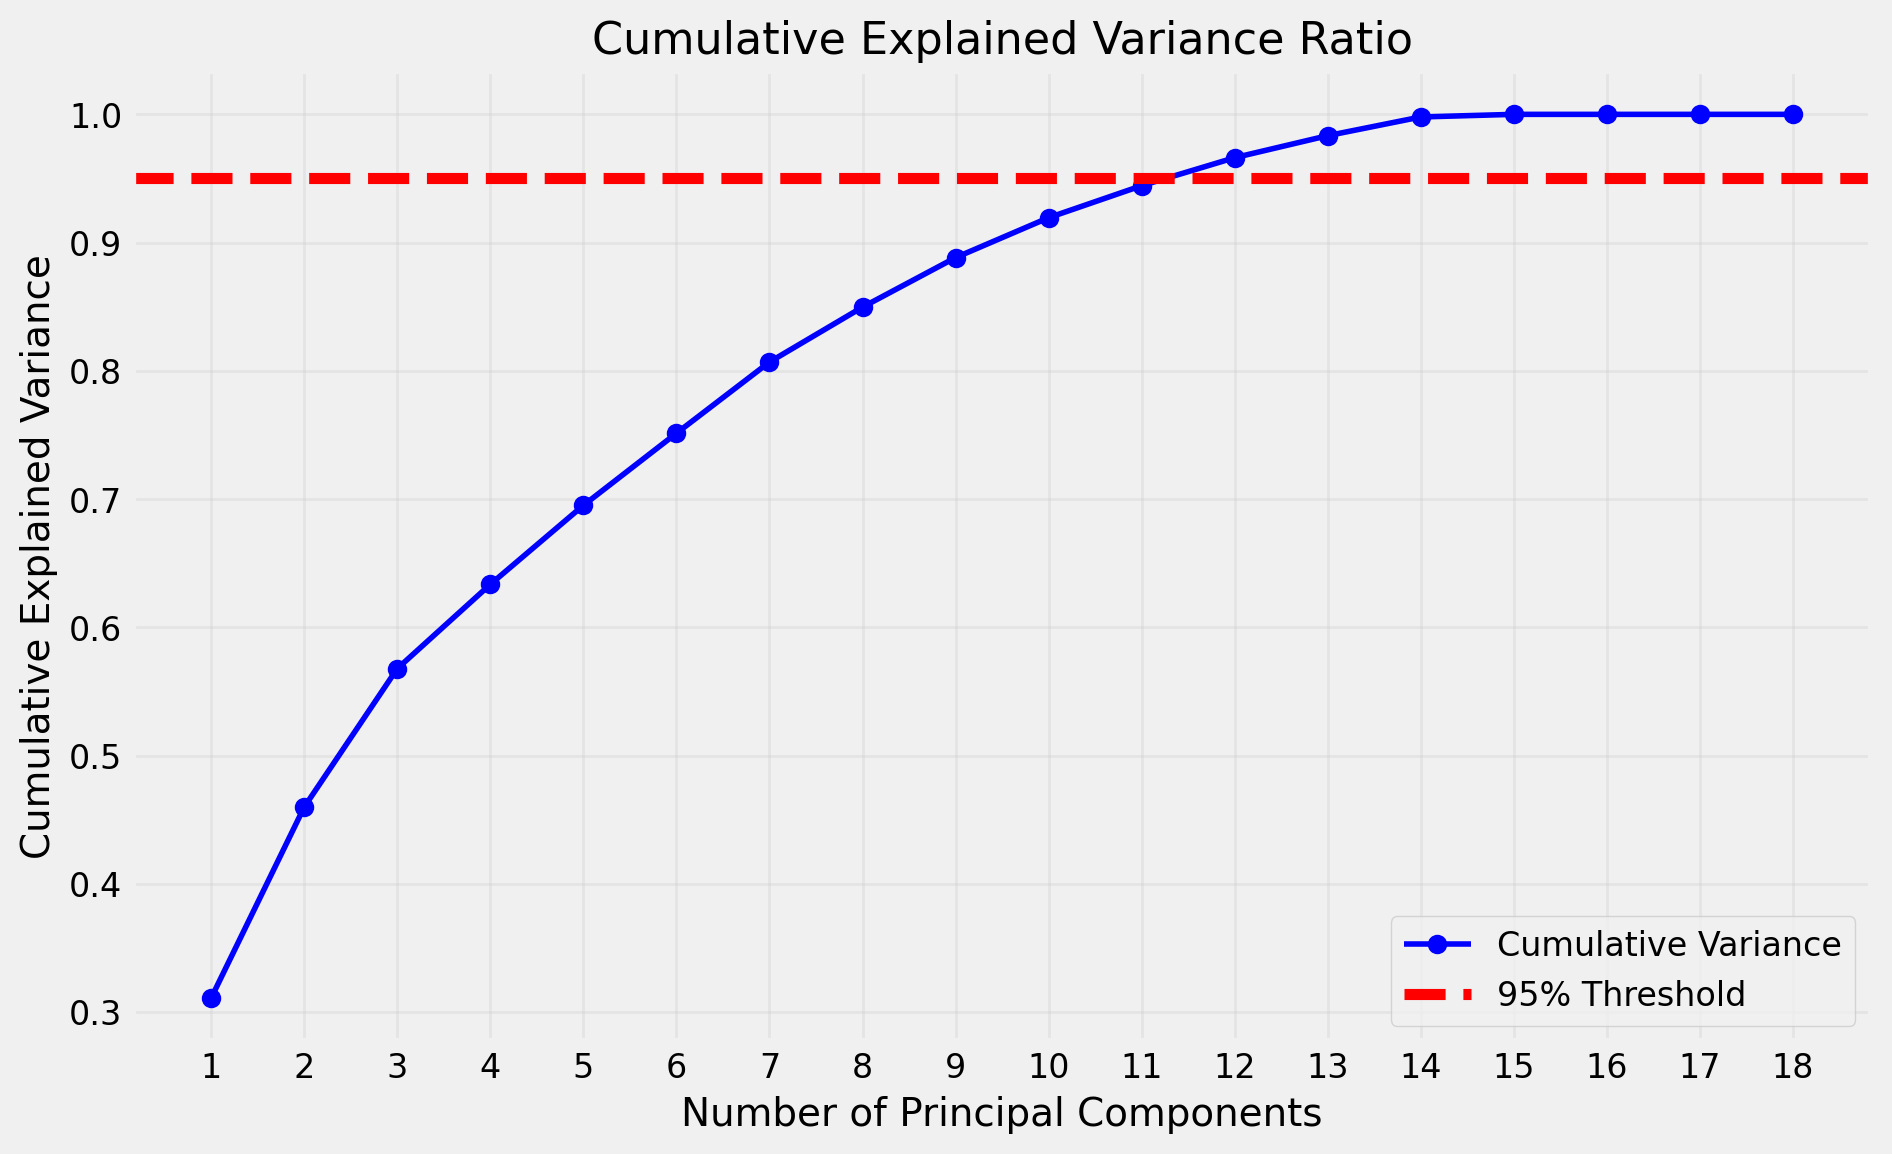

Optimal number of dimensions: 12


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# PCA 수행
pca = PCA()
pca.fit(data_scaled)

# 누적 설명 분산 비율 계산
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# 시각화
plt.figure(figsize=(10, 6))  # 그래프 크기 조정
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', color='blue', linewidth=2, label='Cumulative Variance')
plt.axhline(y=0.95, color='red', linestyle='--', label='95% Threshold')  # 95% 기준선
plt.xticks(ticks=range(1, len(explained_variance) + 1), fontsize=12)  # x축 눈금을 정수로 설정
plt.yticks(fontsize=12)
plt.xlabel('Number of Principal Components', fontsize=14)
plt.ylabel('Cumulative Explained Variance', fontsize=14)
plt.title('Cumulative Explained Variance Ratio', fontsize=16)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# 최적 차원 수 출력
optimal_dims = np.argmax(explained_variance >= 0.95) + 1
print(f"Optimal number of dimensions: {optimal_dims}")

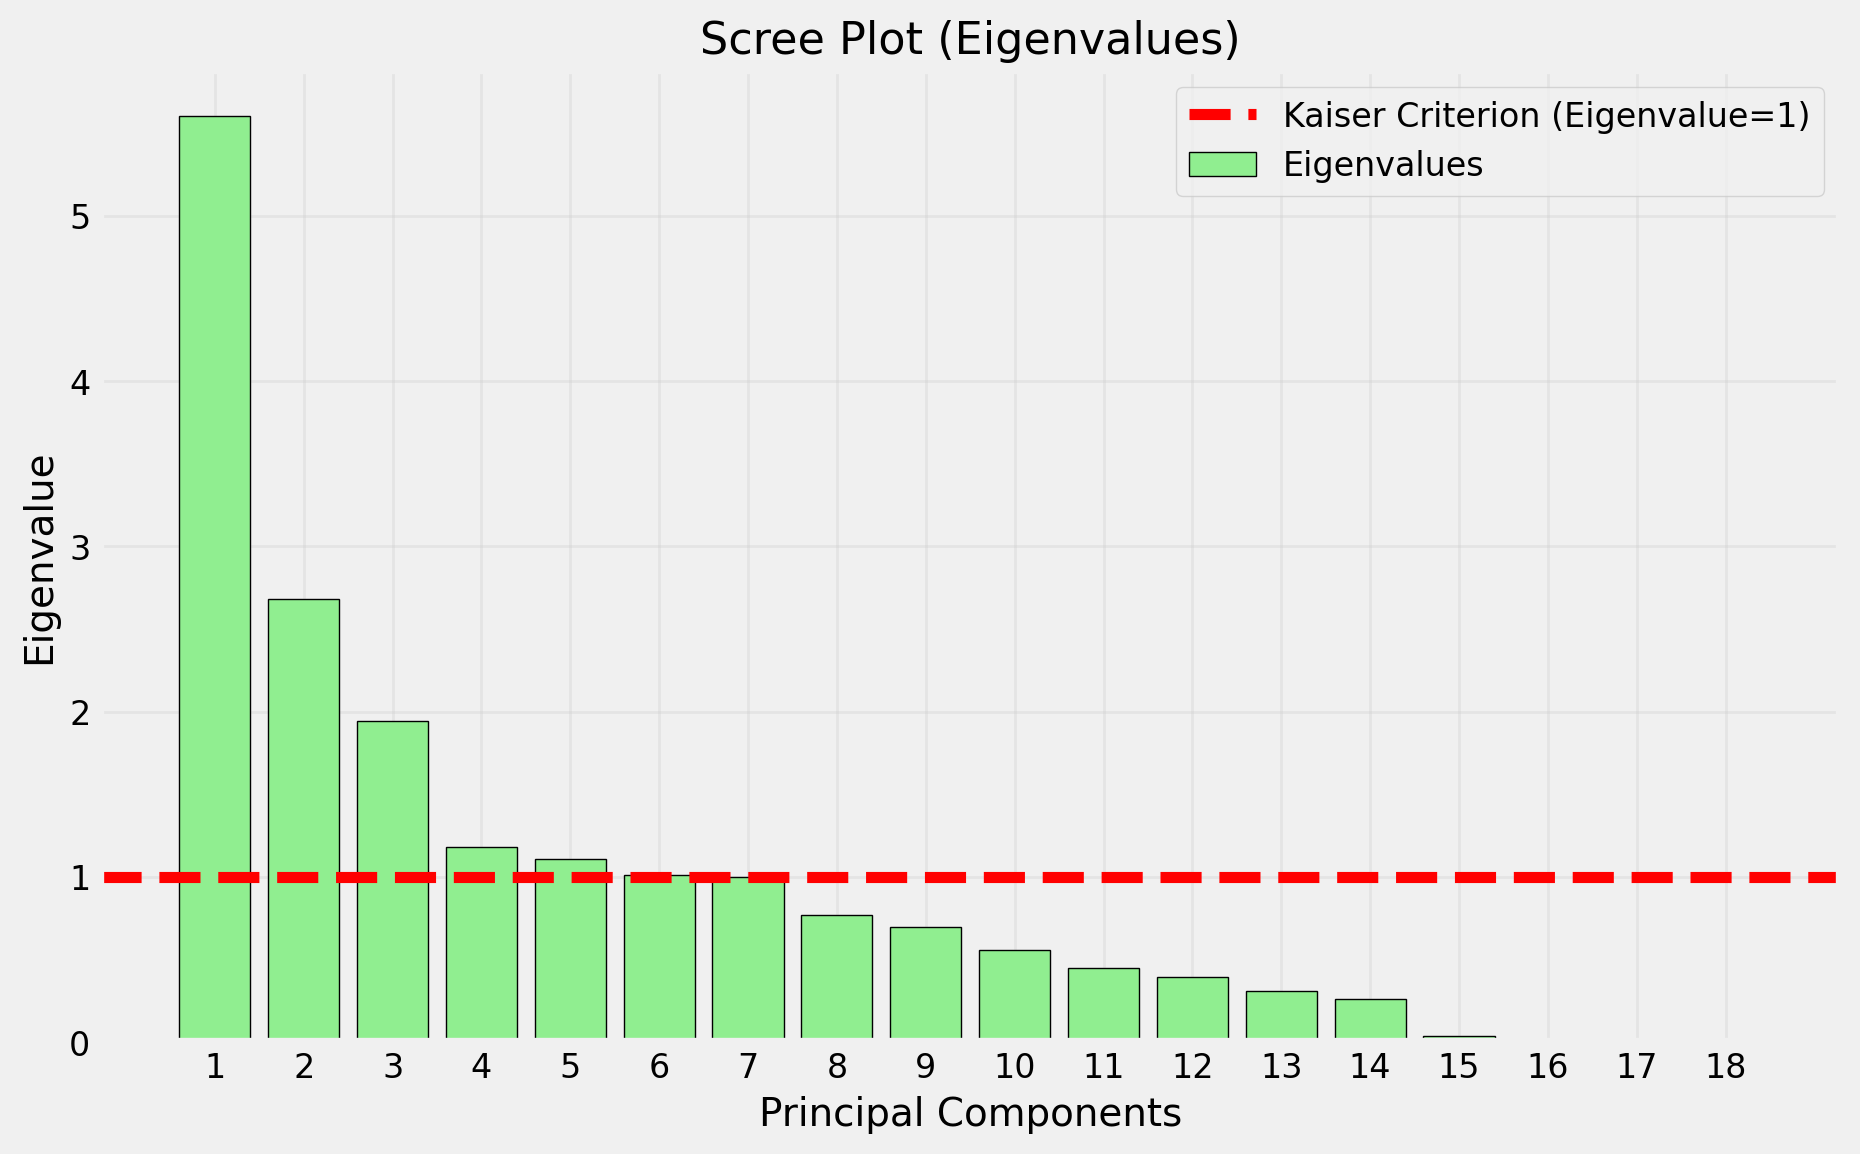

Number of significant components (Eigenvalue >= 1): 7
Principal Component 1:
  - avg_star (Loading: 0.3295)
  - negative_ratio (Loading: -0.3240)
  - neutral_ratio (Loading: 0.3218)
  - 5_ratio (Loading: 0.3147)
  - blank_ratio (Loading: -0.3082)
Principal Component 2:
  - avg_star (Loading: 0.3681)
  - 5_ratio (Loading: 0.3592)
  - avg_emoji_count (Loading: -0.2938)
  - blank_ratio (Loading: 0.2840)
  - 4_ratio (Loading: -0.2815)
Principal Component 3:
  - positive_ratio (Loading: 0.4525)
  - helpful_ratio (Loading: -0.3630)
  - negative_ratio (Loading: -0.3528)
  - avg_emoji_count (Loading: -0.3448)
  - avg_review_len (Loading: -0.3253)
Principal Component 4:
  - helpful_count (Loading: 0.6543)
  - helpful_ratio (Loading: 0.4499)
  - real_count (Loading: -0.2992)
  - avg_review_len (Loading: -0.2424)
  - avg_emoji_count (Loading: -0.2403)
Principal Component 5:
  - one_ratio (Loading: 0.5260)
  - latest_day (Loading: 0.4117)
  - 1_ratio (Loading: 0.3974)
  - 4_ratio (Loading: -0.3415

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# PCA 수행
pca = PCA()
pca.fit(data_scaled)

# 고유값 계산
eigenvalues = pca.explained_variance_

# Scree Plot
plt.figure(figsize=(10, 6))  # 그래프 크기 조정
plt.bar(range(1, len(eigenvalues) + 1), eigenvalues, color='lightgreen', edgecolor='black', label='Eigenvalues')
plt.axhline(y=1, color='red', linestyle='--', label='Kaiser Criterion (Eigenvalue=1)')
plt.xticks(ticks=range(1, len(eigenvalues) + 1), fontsize=12)  # x축 눈금을 정수로 설정
plt.yticks(fontsize=12)
plt.xlabel('Principal Components', fontsize=14)
plt.ylabel('Eigenvalue', fontsize=14)
plt.title('Scree Plot (Eigenvalues)', fontsize=16)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# 유의미한 주성분 수
significant_components = sum(eigenvalues >= 1)
print(f"Number of significant components (Eigenvalue >= 1): {significant_components}")

# 변수 이름 가져오기
feature_names = columns_to_use  # 컬럼 이름 설정

# 유의미한 변수 출력 (PCA 로딩값 활용)
loadings = pca.components_.T  # 변수 x 주성분 매트릭스

# 유의미한 주성분과 변수 출력
significant_loadings = loadings[:, :significant_components]  # 유의미한 주성분에 대한 로딩값
important_features = np.argsort(-np.abs(significant_loadings), axis=0)  # 절대값 기준으로 정렬

# 주성분별 상위 변수 출력
for i in range(significant_components):
    print(f"Principal Component {i + 1}:")
    for feature_idx in important_features[:5, i]:  # 상위 5개의 변수 출력
        print(f"  - {feature_names[feature_idx]} (Loading: {significant_loadings[feature_idx, i]:.4f})")

### 엘보우 메서드

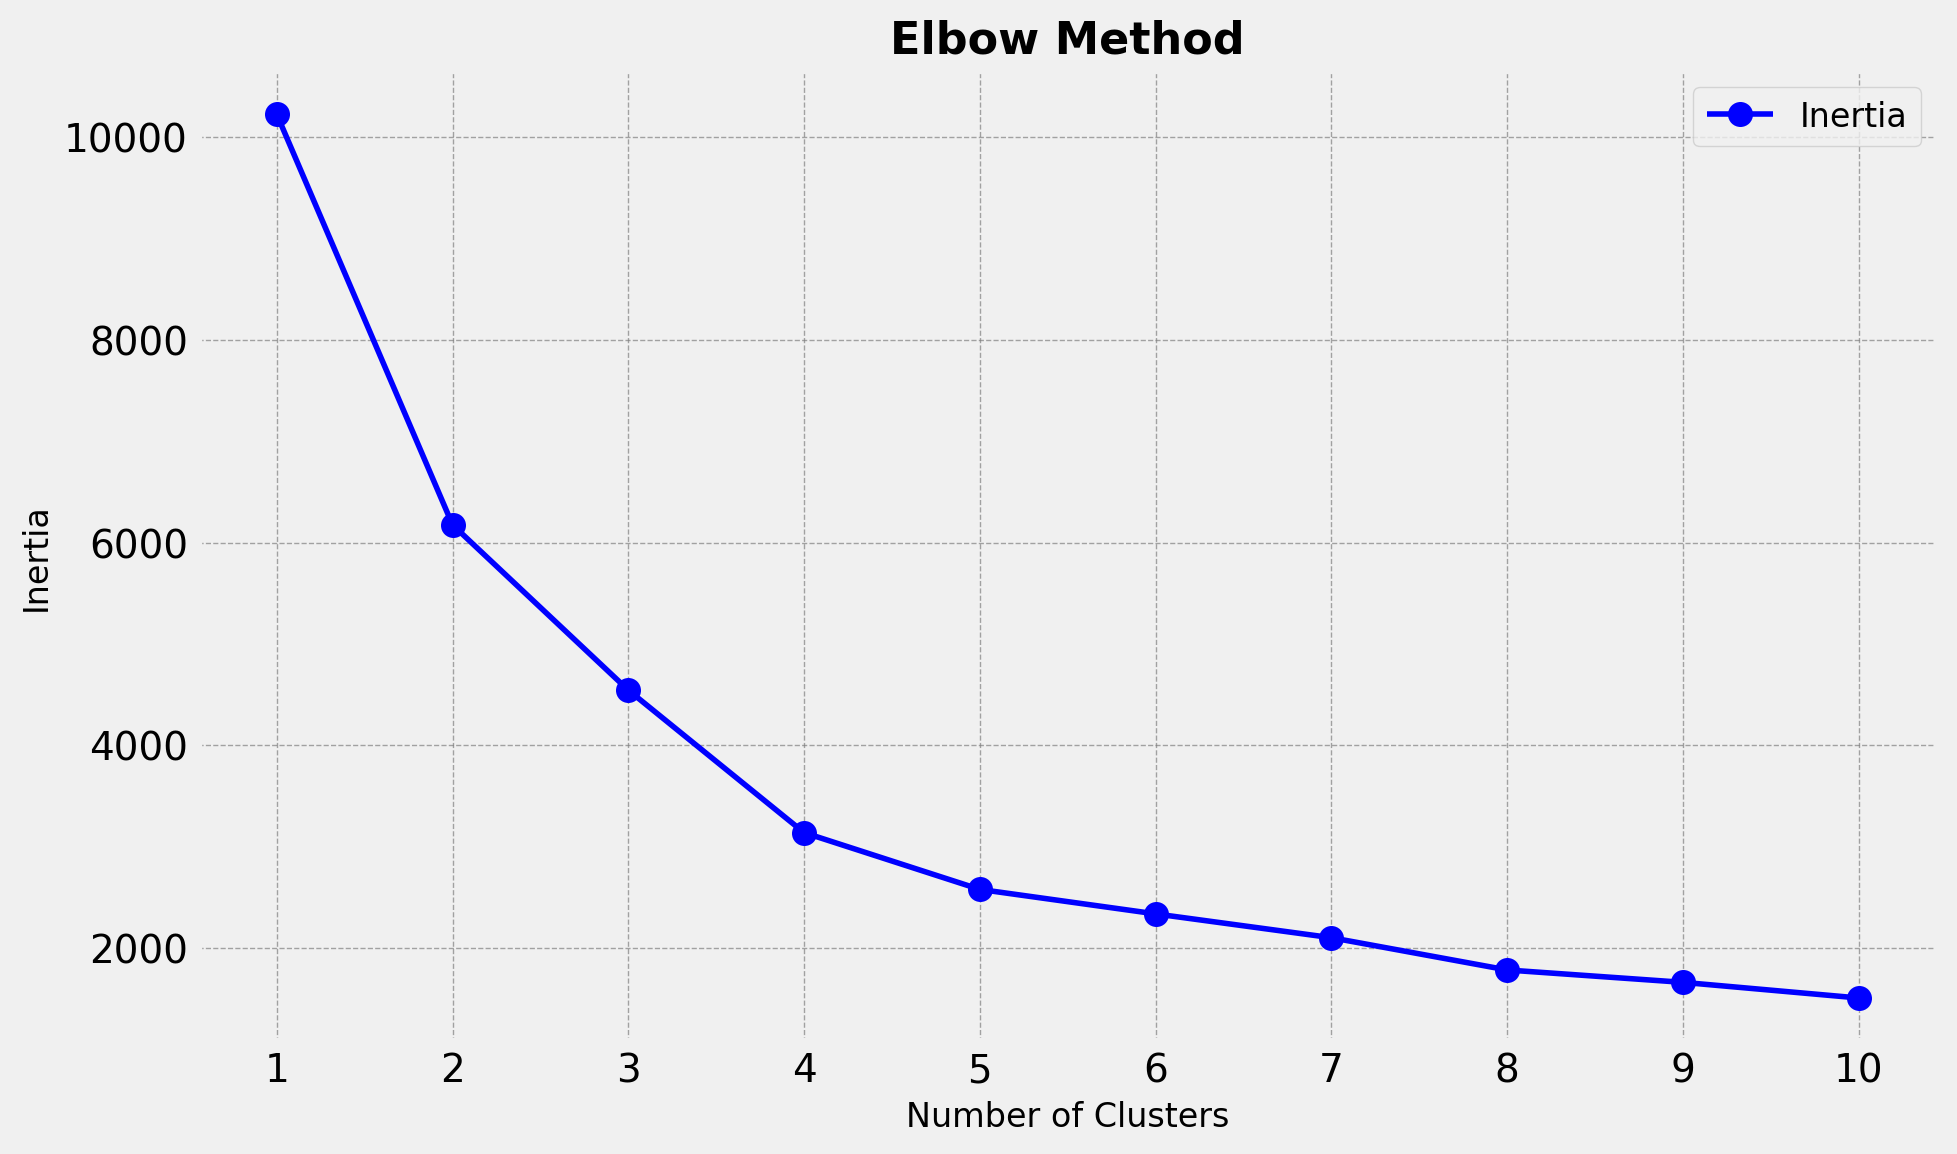

In [ ]:
# 데이터 정규화
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# PCA를 사용한 차원 축소
pca = PCA(n_components=3)
data_pca = pca.fit_transform(data_scaled)

# Elbow Method를 사용한 최적의 클러스터 수 찾기
inertia = []
K = range(1, 11)  # 클러스터 수 1~10
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_pca)
    inertia.append(kmeans.inertia_)

# Elbow Method 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(K, inertia, marker='o', linestyle='-', color='blue', linewidth=2, markersize=8, label='Inertia')
plt.xticks(ticks=K)  # X축에 클러스터 수를 연속적으로 표시
plt.title('Elbow Method', fontsize=16, fontweight='bold')
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)  # 눈금 추가
plt.legend(fontsize=12)
plt.show()

### 실루엣 점수

Silhouette Score for 2 clusters: 0.5137
Silhouette Score for 3 clusters: 0.5180
Silhouette Score for 4 clusters: 0.4212
Silhouette Score for 5 clusters: 0.4360
Silhouette Score for 6 clusters: 0.4289
Silhouette Score for 7 clusters: 0.3813
Silhouette Score for 8 clusters: 0.3720
Silhouette Score for 9 clusters: 0.3624
Silhouette Score for 10 clusters: 0.3654


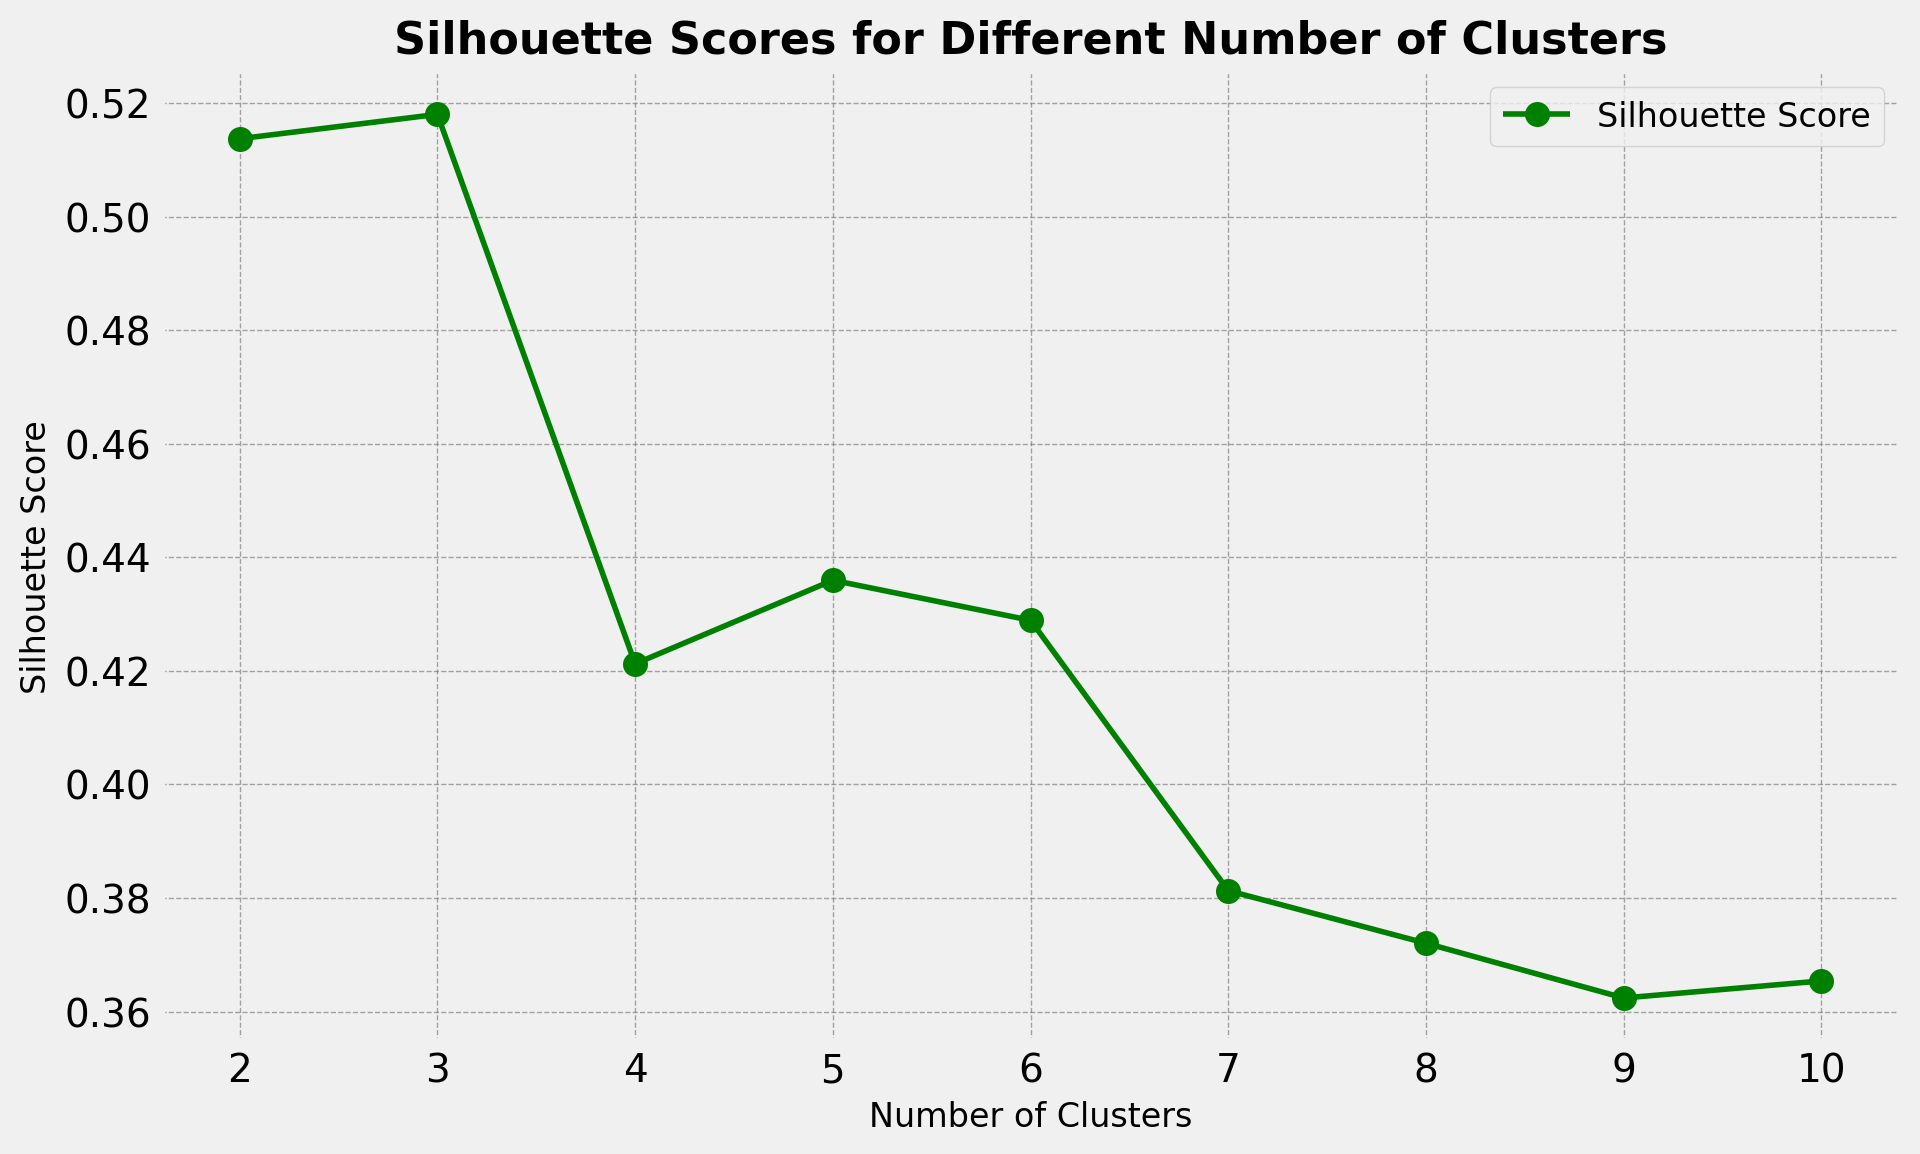

In [ ]:
from sklearn.metrics import silhouette_score

# 실루엣 점수 저장할 리스트
silhouette_scores = []

# K 값을 반복하면서 실루엣 점수 계산
for k in range(2, 11):  # 클러스터 수 2부터 10까지
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(data_pca)
    score = silhouette_score(data_pca, clusters)
    silhouette_scores.append(score)
    print(f'Silhouette Score for {k} clusters: {score:.4f}')

# 실루엣 점수 시각화
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='-', color='green', linewidth=2, markersize=8, label='Silhouette Score')
plt.xticks(ticks=range(2, 11))  # X축 클러스터 수
plt.title('Silhouette Scores for Different Number of Clusters', fontsize=16, fontweight='bold')
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(fontsize=12)
plt.show()

### KMeans 클러스터링

In [ ]:
# 최적 클러스터 수 선택 후 KMeans 클러스터링
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(data_pca)

# 결과를 원본 데이터에 추가
tm['Cluster'] = clusters
tm[['Cluster'] + columns_to_use]

,Cluster,helpful_count,real_count,helpful_ratio,avg_star,5_ratio,4_ratio,3_ratio,2_ratio,1_ratio,blank_ratio,avg_term,latest_day,one_ratio,avg_emoji_count,avg_review_len,positive_ratio,negative_ratio,neutral_ratio
0,0,2,45,0.015,4.089,0.111,0.867,0.022,0.000,0.000,1.000,4.304,8,0.311,0.000,0.000,0.338235,0.661765,0.000000
1,1,497,45,6.455,4.778,0.844,0.111,0.022,0.022,0.000,0.022,17.792,13,0.311,309.400,1254.545,0.426601,0.237077,0.336322
2,0,16,45,0.271,2.422,0.044,0.200,0.089,0.467,0.200,0.800,59.158,74,0.244,3.267,61.778,0.423214,0.310714,0.266071
3,3,1213,45,2.025,4.933,0.933,0.067,0.000,0.000,0.000,0.489,1.615,8,0.044,58.200,656.435,0.385708,0.248558,0.365734
4,1,13380,45,6.847,4.889,0.911,0.067,0.022,0.000,0.000,0.000,2.429,9,0.289,79.733,356.067,0.415913,0.230631,0.353455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,85,45,0.356,5.000,1.000,0.000,0.000,0.000,0.000,0.533,2.160,7,0.289,21.089,199.476,0.457447,0.217079,0.325474
996,3,434,45,1.121,4.911,0.933,0.044,0.022,0.000,0.000,0.067,14.000,55,0.022,23.489,110.310,0.511953,0.190438,0.297609
997,4,120,45,0.952,4.356,0.689,0.133,0.089,0.022,0.067,0.511,89.571,364,0.289,12.089,92.727,0.415060,0.268072,0.316867
998,1,1721,45,5.661,5.000,1.000,0.000,0.000,0.000,0.000,0.000,4.278,19,0.111,290.267,1095.378,0.422885,0.248925,0.328190


In [ ]:
tm.groupby('Cluster')[ ['helpful_count', 'real_count', 'helpful_ratio', 'avg_star', '5_ratio', '4_ratio', '3_ratio', '2_ratio', '1_ratio', 'blank_ratio', 'avg_term', 'latest_day', 'one_ratio', 'avg_emoji_count',
                        'avg_review_len', 'positive_ratio', 'negative_ratio', 'neutral_ratio']].mean().sort_values(by='helpful_count', ascending=False)

,helpful_count,real_count,helpful_ratio,avg_star,5_ratio,4_ratio,3_ratio,2_ratio,1_ratio,blank_ratio,avg_term,latest_day,one_ratio,avg_emoji_count,avg_review_len,positive_ratio,negative_ratio,neutral_ratio
Cluster,,,,,,,,,,,,,,,,,,
1,8168.516014,46.619217,10.169833,4.919854,0.937263,0.049804,0.009577,0.002103,0.001178,0.062580,5.278267,19.743772,0.230114,185.930765,830.491925,0.419828,0.237763,0.342410
4,1958.585366,45.000000,2.879585,4.197549,0.537098,0.284049,0.081817,0.033195,0.063622,0.372878,41.205890,81.512195,0.276707,33.852293,202.118537,0.425251,0.266619,0.308131
3,1461.255230,45.041841,1.570050,4.929906,0.953831,0.031048,0.009502,0.002347,0.003190,0.317910,12.139301,46.928870,0.200732,39.296113,258.415395,0.457124,0.221741,0.321135
2,353.047244,45.000000,0.294189,4.760323,0.849236,0.095181,0.034567,0.008693,0.012173,0.972283,79.746457,143.023622,0.074654,0.477693,43.282685,0.359282,0.575098,0.065620
0,90.093750,45.156250,0.422594,3.555750,0.183031,0.408469,0.247000,0.104063,0.057219,0.873250,49.343875,90.843750,0.110531,2.308156,36.883812,0.367960,0.526520,0.105520


### ANOVA: 클러스터 간 유의미한 변수 파악

## [테무]

### 차원 축소(PCA)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 사용할 컬럼 선택
columns_to_use = ['helpful_count', 'total_review', 'helpful_ratio', 'avg_star',
                  '5_raito', '4_ratio', '3_ratio', '2_ratio', '1_ratio',
                  'avg_review_len', 'blank_ratio', 'avg_term', 'latest_day',
                  'one_ratio', 'avg_emoji_count', 'positive_ratio',
                  'negative_ratio', 'neutral_ratio']
data = tm[columns_to_use]

# 데이터 정규화
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

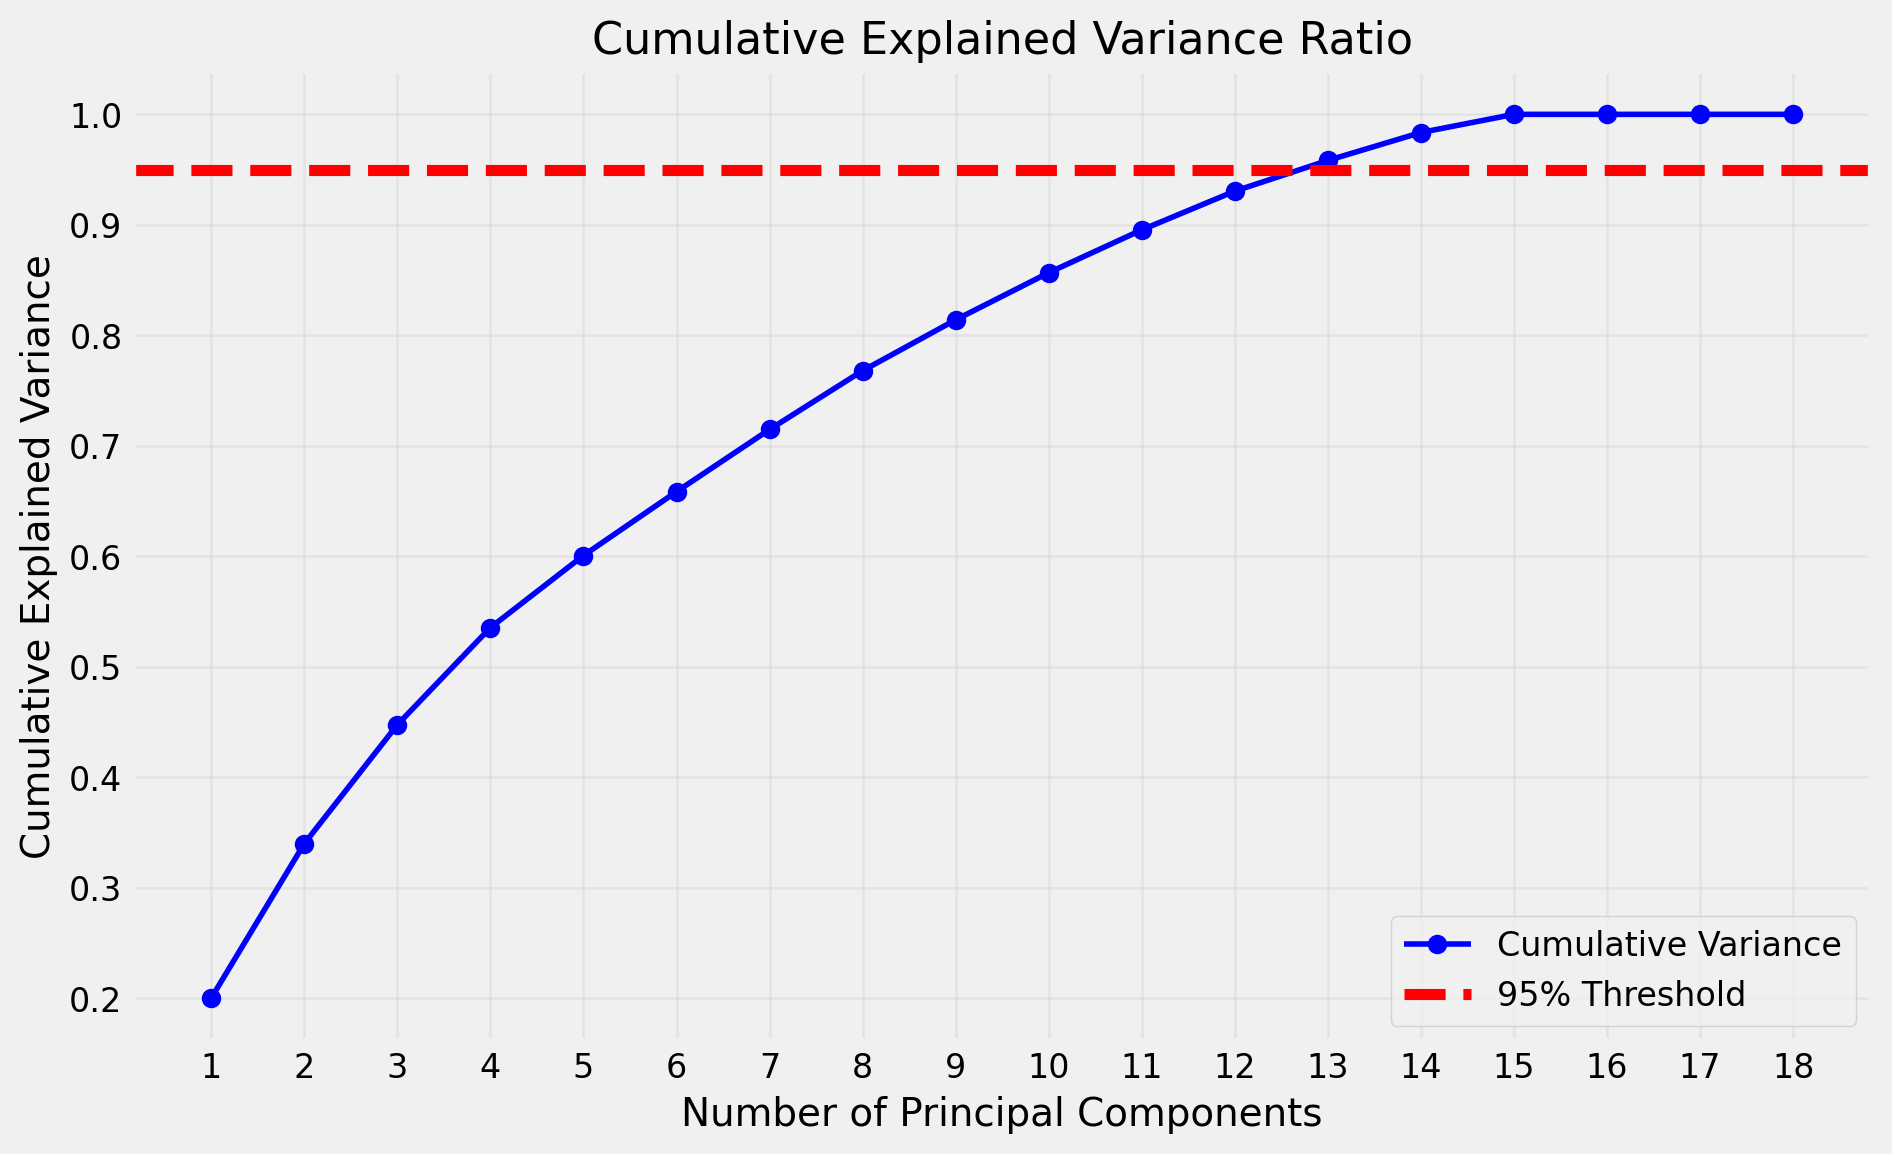

Optimal number of dimensions: 13


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# PCA 수행
pca = PCA()
pca.fit(data_scaled)

# 누적 설명 분산 비율 계산
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# 시각화
plt.figure(figsize=(10, 6))  # 그래프 크기 조정
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', color='blue', linewidth=2, label='Cumulative Variance')
plt.axhline(y=0.95, color='red', linestyle='--', label='95% Threshold')  # 95% 기준선
plt.xticks(ticks=range(1, len(explained_variance) + 1), fontsize=12)  # x축 눈금을 정수로 설정
plt.yticks(fontsize=12)
plt.xlabel('Number of Principal Components', fontsize=14)
plt.ylabel('Cumulative Explained Variance', fontsize=14)
plt.title('Cumulative Explained Variance Ratio', fontsize=16)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# 최적 차원 수 출력
optimal_dims = np.argmax(explained_variance >= 0.95) + 1
print(f"Optimal number of dimensions: {optimal_dims}")

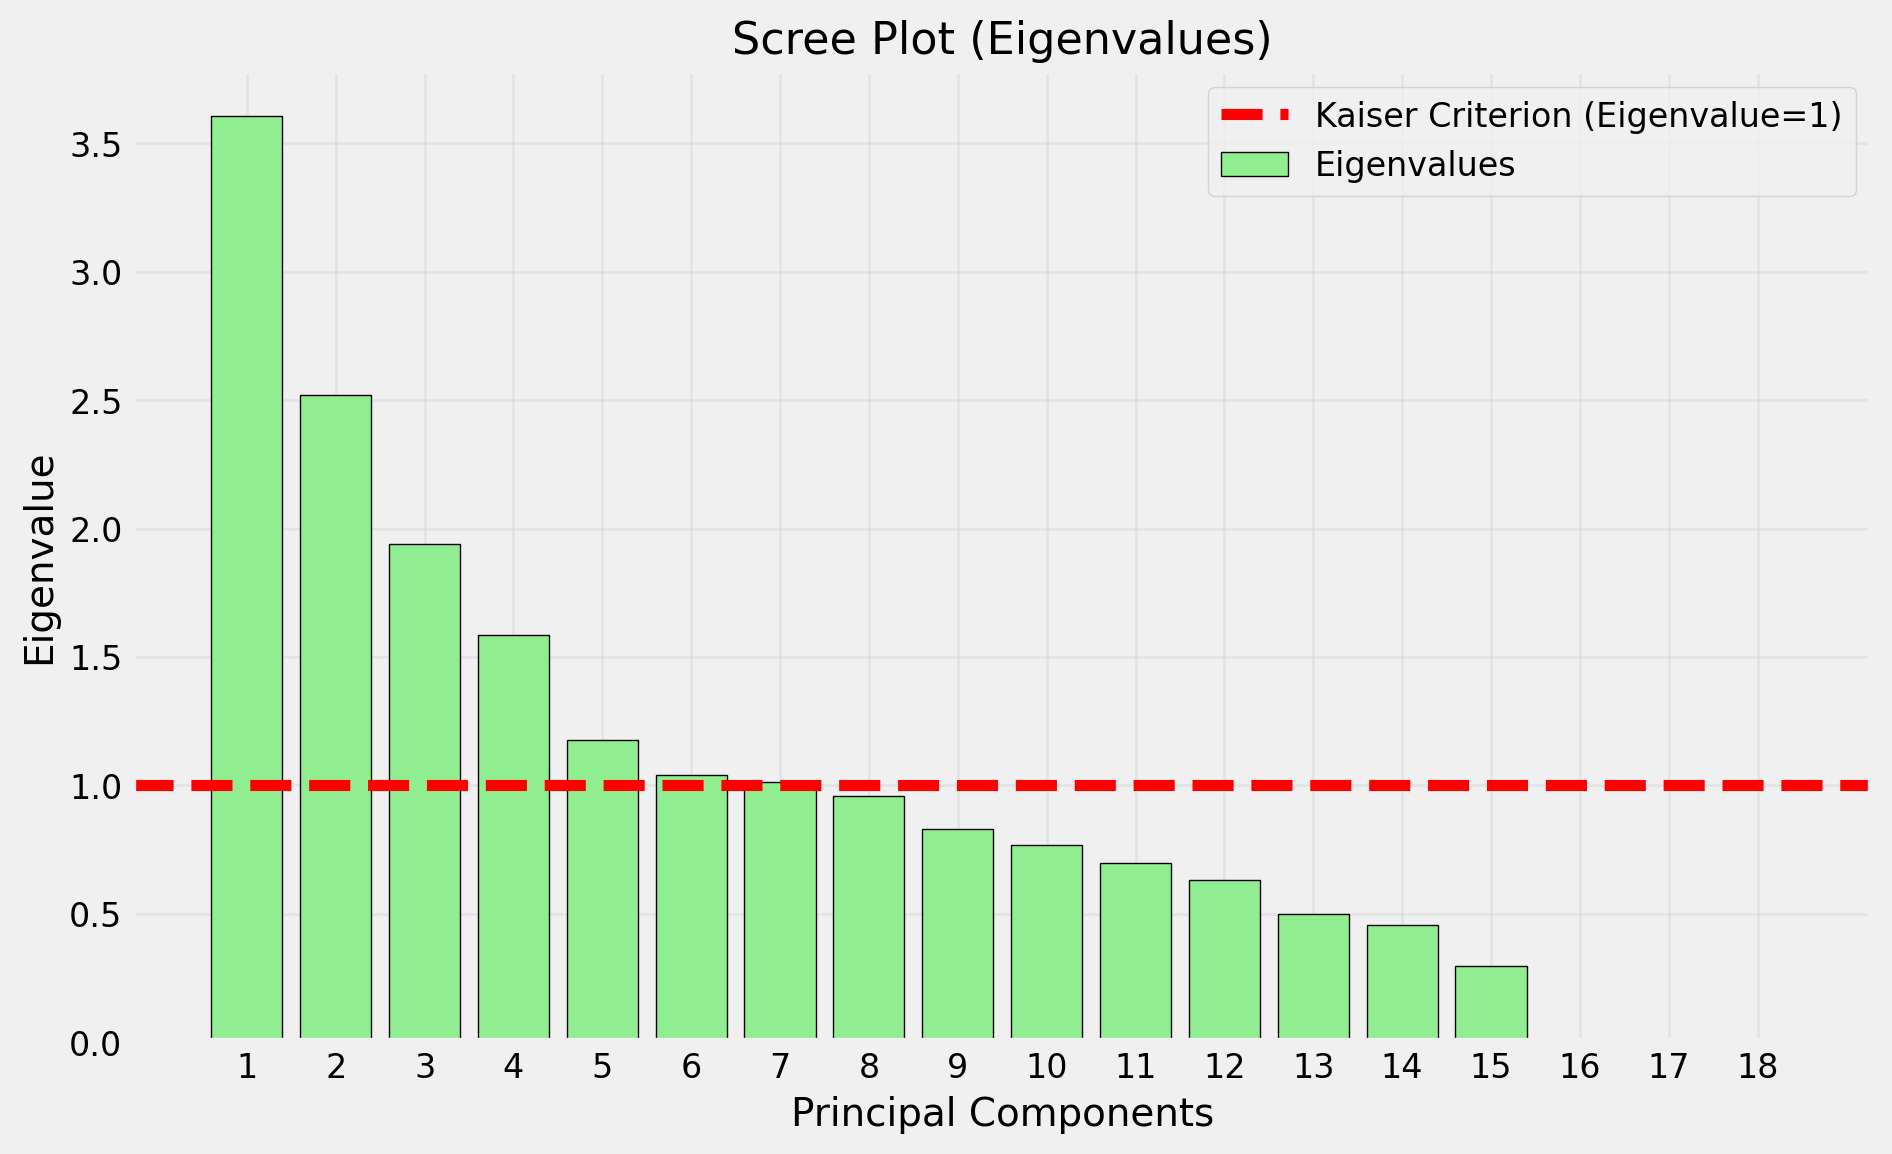

Number of significant components (Eigenvalue >= 1): 7
Principal Component 1:
  - avg_star (Loading: 0.5148)
  - 5_raito (Loading: 0.4826)
  - 3_ratio (Loading: -0.4009)
  - 2_ratio (Loading: -0.3536)
  - 4_ratio (Loading: -0.2844)
Principal Component 2:
  - negative_ratio (Loading: 0.5432)
  - neutral_ratio (Loading: -0.4703)
  - avg_review_len (Loading: -0.3421)
  - positive_ratio (Loading: -0.3361)
  - blank_ratio (Loading: 0.3046)
Principal Component 3:
  - total_review (Loading: 0.5036)
  - helpful_count (Loading: 0.4851)
  - latest_day (Loading: -0.3182)
  - negative_ratio (Loading: 0.2966)
  - positive_ratio (Loading: -0.2302)
Principal Component 4:
  - helpful_ratio (Loading: 0.4440)
  - one_ratio (Loading: 0.4041)
  - 4_ratio (Loading: -0.3723)
  - 1_ratio (Loading: 0.3280)
  - avg_review_len (Loading: 0.3108)
Principal Component 5:
  - 4_ratio (Loading: 0.5220)
  - 1_ratio (Loading: -0.4082)
  - one_ratio (Loading: 0.3950)
  - total_review (Loading: -0.3232)
  - 2_ratio (Loadi

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# PCA 수행
pca = PCA()
pca.fit(data_scaled)

# 고유값 계산
eigenvalues = pca.explained_variance_

# Scree Plot
plt.figure(figsize=(10, 6))  # 그래프 크기 조정
plt.bar(range(1, len(eigenvalues) + 1), eigenvalues, color='lightgreen', edgecolor='black', label='Eigenvalues')
plt.axhline(y=1, color='red', linestyle='--', label='Kaiser Criterion (Eigenvalue=1)')
plt.xticks(ticks=range(1, len(eigenvalues) + 1), fontsize=12)  # x축 눈금을 정수로 설정
plt.yticks(fontsize=12)
plt.xlabel('Principal Components', fontsize=14)
plt.ylabel('Eigenvalue', fontsize=14)
plt.title('Scree Plot (Eigenvalues)', fontsize=16)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# 유의미한 주성분 수
significant_components = sum(eigenvalues >= 1)
print(f"Number of significant components (Eigenvalue >= 1): {significant_components}")

# 변수 이름 가져오기
feature_names = columns_to_use  # 컬럼 이름 설정

# 유의미한 변수 출력 (PCA 로딩값 활용)
loadings = pca.components_.T  # 변수 x 주성분 매트릭스

# 유의미한 주성분과 변수 출력
significant_loadings = loadings[:, :significant_components]  # 유의미한 주성분에 대한 로딩값
important_features = np.argsort(-np.abs(significant_loadings), axis=0)  # 절대값 기준으로 정렬

# 주성분별 상위 변수 출력
for i in range(significant_components):
    print(f"Principal Component {i + 1}:")
    for feature_idx in important_features[:5, i]:  # 상위 5개의 변수 출력
        print(f"  - {feature_names[feature_idx]} (Loading: {significant_loadings[feature_idx, i]:.4f})")

### 엘보우 메서드

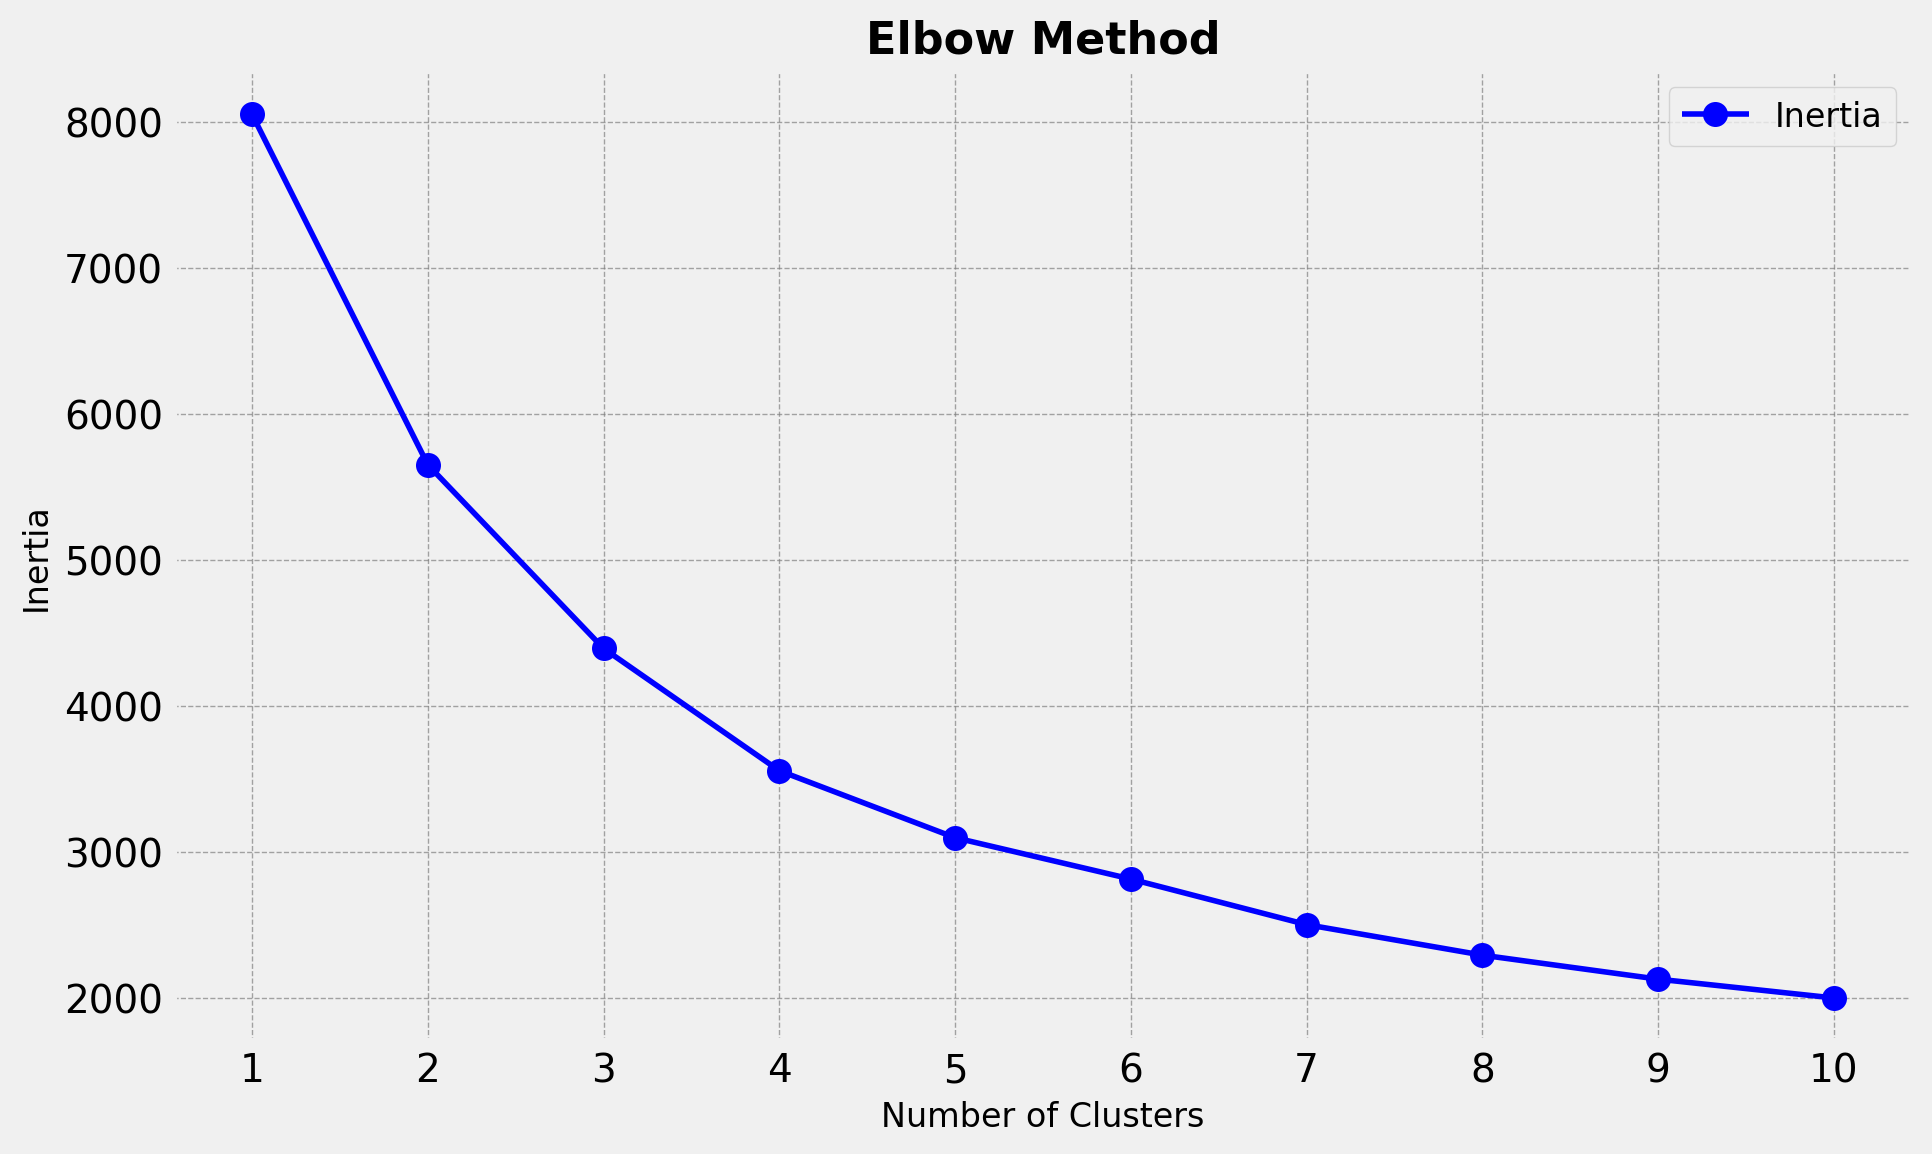

In [ ]:
# 데이터 정규화
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# PCA를 사용한 차원 축소
pca = PCA(n_components=3)
data_pca = pca.fit_transform(data_scaled)

# Elbow Method를 사용한 최적의 클러스터 수 찾기
inertia = []
K = range(1, 11)  # 클러스터 수 1~10
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_pca)
    inertia.append(kmeans.inertia_)

# Elbow Method 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(K, inertia, marker='o', linestyle='-', color='blue', linewidth=2, markersize=8, label='Inertia')
plt.xticks(ticks=K)  # X축에 클러스터 수를 연속적으로 표시
plt.title('Elbow Method', fontsize=16, fontweight='bold')
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)  # 눈금 추가
plt.legend(fontsize=12)
plt.show()

### 실루엣 점수

Silhouette Score for 2 clusters: 0.3119
Silhouette Score for 3 clusters: 0.2783
Silhouette Score for 4 clusters: 0.2910
Silhouette Score for 5 clusters: 0.2679
Silhouette Score for 6 clusters: 0.2324
Silhouette Score for 7 clusters: 0.2516
Silhouette Score for 8 clusters: 0.2593
Silhouette Score for 9 clusters: 0.2465
Silhouette Score for 10 clusters: 0.2394


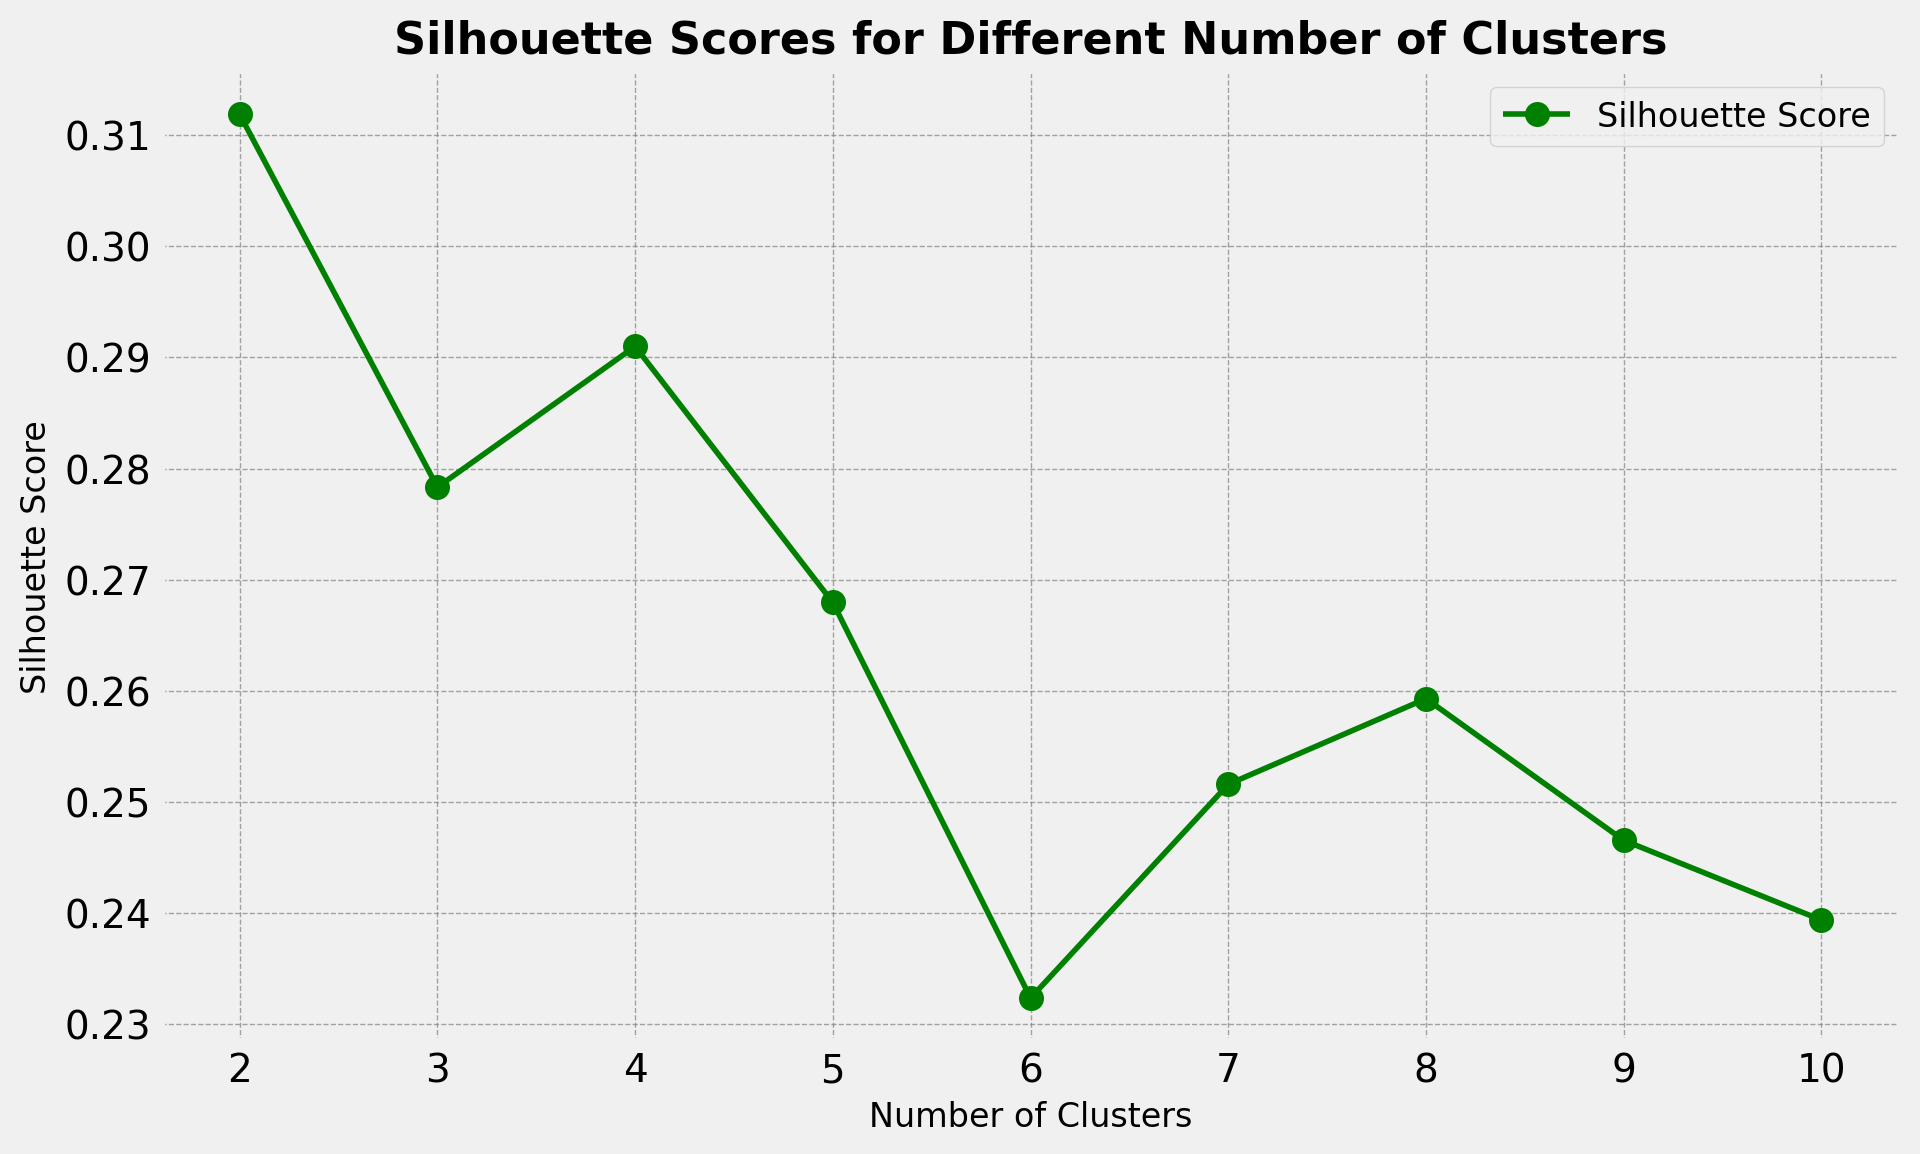

In [ ]:
from sklearn.metrics import silhouette_score

# 실루엣 점수 저장할 리스트
silhouette_scores = []

# K 값을 반복하면서 실루엣 점수 계산
for k in range(2, 11):  # 클러스터 수 2부터 10까지
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(data_pca)
    score = silhouette_score(data_pca, clusters)
    silhouette_scores.append(score)
    print(f'Silhouette Score for {k} clusters: {score:.4f}')

# 실루엣 점수 시각화
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='-', color='green', linewidth=2, markersize=8, label='Silhouette Score')
plt.xticks(ticks=range(2, 11))  # X축 클러스터 수
plt.title('Silhouette Scores for Different Number of Clusters', fontsize=16, fontweight='bold')
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(fontsize=12)
plt.show()

### KMeans 클러스터링

In [ ]:
# 최적 클러스터 수 선택 후 KMeans 클러스터링
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(data_pca)

# 결과를 원본 데이터에 추가
tm['Cluster'] = clusters
tm[['Cluster'] + columns_to_use]

,Cluster,helpful_count,total_review,helpful_ratio,avg_star,5_raito,4_ratio,3_ratio,2_ratio,1_ratio,avg_review_len,blank_ratio,avg_term,latest_day,one_ratio,avg_emoji_count,positive_ratio,negative_ratio,neutral_ratio
0,1,209,512,0.408,4.547,0.730,0.146,0.082,0.021,0.020,33.982,0.227,5.767,11,0.008,0.404,0.419584,0.332456,0.247960
1,3,1,51,0.020,4.098,0.471,0.275,0.176,0.039,0.039,9.215,0.000,10.250,308,0.039,0.000,0.430473,0.329882,0.239645
2,2,1,19,0.053,4.211,0.579,0.263,0.053,0.000,0.105,45.056,0.053,26.250,11,0.053,1.611,0.505051,0.194805,0.300144
3,0,11,326,0.034,4.129,0.610,0.144,0.095,0.064,0.086,5.798,0.218,2.944,2,0.003,0.000,0.380909,0.457273,0.161818
4,2,7,299,0.023,4.913,0.930,0.054,0.017,0.000,0.000,10.800,0.117,2.222,2,0.000,0.000,0.401668,0.324531,0.273801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2,29,60,0.483,4.667,0.867,0.033,0.050,0.000,0.050,37.083,0.000,8.267,8,0.083,0.033,0.375133,0.403415,0.221451
996,0,4,32,0.125,4.625,0.844,0.031,0.062,0.031,0.031,14.200,0.688,90.500,122,0.000,0.100,0.360190,0.478673,0.161137
997,3,0,52,0.000,3.942,0.462,0.269,0.096,0.096,0.077,17.698,0.173,40.167,98,0.038,0.512,0.421192,0.333775,0.245033
998,0,4,38,0.105,4.816,0.816,0.184,0.000,0.000,0.000,12.688,0.579,15.250,36,0.000,0.188,0.440141,0.366197,0.193662


In [ ]:
tm.groupby('Cluster')[['helpful_count', 'total_review', 'helpful_ratio', 'avg_star', '5_raito', '4_ratio', '3_ratio', '2_ratio', '1_ratio', 'avg_review_len', 'blank_ratio', 'avg_term', 'latest_day',
                  'one_ratio', 'avg_emoji_count', 'positive_ratio', 'negative_ratio', 'neutral_ratio']].mean().sort_values(by='helpful_count', ascending=False)

,helpful_count,total_review,helpful_ratio,avg_star,5_raito,4_ratio,3_ratio,2_ratio,1_ratio,avg_review_len,blank_ratio,avg_term,latest_day,one_ratio,avg_emoji_count,positive_ratio,negative_ratio,neutral_ratio
Cluster,,,,,,,,,,,,,,,,,,
1,195.536585,402.280488,0.753500,4.557854,0.687598,0.232073,0.047439,0.016415,0.016427,42.322659,0.077671,9.634037,20.670732,0.012695,0.936268,0.406015,0.389361,0.204624
2,18.220736,97.043478,0.236378,4.685328,0.805278,0.126090,0.035873,0.014211,0.018522,27.820946,0.169896,21.190274,78.695652,0.029217,0.261676,0.452281,0.293894,0.253825
0,13.386423,118.208877,0.127504,4.641128,0.770812,0.153243,0.041841,0.014402,0.019663,19.729548,0.286172,19.456371,63.402089,0.023715,0.155251,0.387733,0.468439,0.143828
3,10.932203,87.860169,0.142000,3.798992,0.344025,0.339178,0.165229,0.074907,0.076623,25.893424,0.160826,23.534733,90.673729,0.024593,0.161013,0.404726,0.386275,0.208998


### ANOVA: 클러스터 간 유의미한 변수 파악

In [ ]:
import easydict
args = easydict.EasyDict()

# path 정보
args.default_path = '/content/data/MyDrive/Dart-B/4기 학술제/'
args.csv1 = args.default_path+'테무 클러스터링 2차.csv'
df = pd.read_csv(args.csv1)

In [ ]:
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd


# 클러스터가 포함된 DataFrame 및 분석 대상 칼럼 리스트
columns_to_use = ['helpful_count', 'total_review', 'helpful_ratio', 'avg_star',
                  '5_raito', '4_ratio', '3_ratio', '2_ratio', '1_ratio',
                  'avg_review_len', 'blank_ratio', 'avg_term', 'latest_day',
                  'one_ratio', 'avg_emoji_count', 'positive_ratio',
                  'negative_ratio', 'neutral_ratio']

# 결과 저장을 위한 리스트
anova_results = []
significant_columns = []

# 각 칼럼에 대해 ANOVA 수행
for col in columns_to_use:
    # 클러스터별 데이터 추출
    cluster_groups = [df[col][df['Cluster'] == cluster] for cluster in df['Cluster'].unique()]

    # 분산분석 (ANOVA)
    f_stat, p_value = f_oneway(*cluster_groups)
    anova_results.append((col, f_stat, p_value))

    # 유의미한 경우만 저장
    if p_value < 0.05:
        significant_columns.append(col)
        print(f"{col}: ANOVA significant (p = {p_value:.4f})")

        # 사후 분석 (Tukey HSD Test)
        tukey_result = pairwise_tukeyhsd(df[col], df['Cluster'])
        print(f"Tukey HSD Test for {col}:")
        print(tukey_result)
        print()


helpful_count: ANOVA significant (p = 0.0000)
Tukey HSD Test for helpful_count:
   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower     upper   reject
---------------------------------------------------------
     0      1  182.1502    0.0  164.2379  200.0624   True
     0      2    4.8343 0.6926   -6.5259   16.1945  False
     0      3   -2.4542 0.9547  -14.6362    9.7278  False
     1      2 -177.3158    0.0 -195.6664 -158.9653   True
     1      3 -184.6044    0.0 -203.4747  -165.734   True
     2      3   -7.2885 0.4602  -20.1064    5.5293  False
---------------------------------------------------------

total_review: ANOVA significant (p = 0.0000)
Tukey HSD Test for total_review:
   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower     upper   reject
---------------------------------------------------------
     0      1  284.0716    0.0  245.3742   322.769   True
     0      2  -21.1654 0.118

In [ ]:
grouped_means = df.groupby('Cluster')[columns_to_use].mean()
grouped_means

,helpful_count,total_review,helpful_ratio,avg_star,5_raito,4_ratio,3_ratio,2_ratio,1_ratio,avg_review_len,blank_ratio,avg_term,latest_day,one_ratio,avg_emoji_count,positive_ratio,negative_ratio,neutral_ratio
Cluster,,,,,,,,,,,,,,,,,,
0,13.386423,118.208877,0.127504,4.641128,0.770812,0.153243,0.041841,0.014402,0.019663,19.729548,0.286172,19.456371,63.402089,0.023715,0.155251,0.387733,0.468439,0.143828
1,195.536585,402.280488,0.753500,4.557854,0.687598,0.232073,0.047439,0.016415,0.016427,42.322659,0.077671,9.634037,20.670732,0.012695,0.936268,0.406015,0.389361,0.204624
2,18.220736,97.043478,0.236378,4.685328,0.805278,0.126090,0.035873,0.014211,0.018522,27.820946,0.169896,21.190274,78.695652,0.029217,0.261676,0.452281,0.293894,0.253825
3,10.932203,87.860169,0.142000,3.798992,0.344025,0.339178,0.165229,0.074907,0.076623,25.893424,0.160826,23.534733,90.673729,0.024593,0.161013,0.404726,0.386275,0.208998


In [ ]:
df['Cluster'].value_counts()

,count
Cluster,
0,383
2,299
3,236
1,82
